# Capstone Project - Drivvo App

Drivvo is a mobile app to record and keep track of vehicle expenses and keep on top of regular maintenance.
Currently the app's main function is to create reports of the vehicle services and expenses based on the users inputs.

## Objective

The objective of this project is to make the app more consultative, trying to predict when the vehicle will need a service.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

#plt.style.use('fivethirtyeight')
plt.style.use('ggplot')
sns.set_style("whitegrid")
sns.set(font_scale=1.5)

%config InlineBackend.figure_format = 'retina'
%matplotlib inline


The drivvo database is stored in a PostgreSQL system with more than 30 tables.
The first step of this project was to identify which columns from all the tables could be used for predicting a vehicle service.
I used SQL commands to extract the data needed and saved it into a csv file.
Initially I'm just going to use data from Brazil (country with largest number of users).

In [2]:
df = pd.read_csv('drivvo.csv')

## EDA

### Data Dictionary

In [3]:
drivvo_dict = {'odometer': 'odometer reading in kilometers or miles at the moment of the vehicle serive. Inpuyted by user',
              'date': 'date of the vehicle service',
              'service_id': 'unique id per service type',
              'service': 'name of the vehicle service',
              'vehicle_id': 'unique id per vehicle',
              'vehicle_type': 'type of the vehicle. 1 = Car; 2 = Motorcycle; 3 = Bus; 4 = Truck',
              'brand': 'unique id per brand',
              'vehicle_year': 'vehicle year. Inputted by user',
              'model': 'model of the vehicle. Inputted by user',
              'fuel_type': 'Type (state) of the vehicle fuel. 1= Liquid; 2= liquefied petroleum gas (lpg); 3= compressed natural gas (cng);\
               4= electric',
              'fuel_volume': "Vehicle's fuel tank volume. Inputted by user",
              'fuel_volume2': "Vehicle's second fuel tank volume (when applicable). Inputted by user",
              'distance_unity': 'Distance unity on the odometer reader. 1= Kilometers; 2= Miles',
              'currency': "currency",
              'language_': "user's language",
              'country': "user's country",
              'latitude': "user's latitude location",
              'longitude': "user's longitude location"}

### Setting the Country

In [4]:
# EDA 
df.shape

(881634, 18)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881634 entries, 0 to 881633
Data columns (total 18 columns):
odometer          881634 non-null int64
date              881634 non-null object
service_id        881634 non-null int64
service           881631 non-null object
vehicle_id        881634 non-null int64
vehicle_type      881634 non-null int64
brand             879906 non-null float64
vehicle_year      870203 non-null float64
model             881544 non-null object
fuel_type         881634 non-null int64
fuel_volume       881634 non-null float64
fuel_volume2      846045 non-null float64
distance_unity    859032 non-null float64
currency          881634 non-null object
language_         881634 non-null object
country           720811 non-null object
latitude          748168 non-null float64
longitude         748168 non-null float64
dtypes: float64(7), int64(5), object(6)
memory usage: 121.1+ MB


In [6]:
## The Country, latitude and longitude variables have a great number of null values, therefore I'm using the currency
## as indicator of country. 
df.currency.value_counts()

BRL       843265
pt_BR      38310
BRR           24
BRN           14
BRE           10
BRZ            6
es_BR          3
brx_IN         2
Name: currency, dtype: int64

In [7]:
## Dropping the currencies that are not BRL or pt_BR
df = df[(df.currency == 'BRL') | (df.currency == 'pt_BR')]

In [8]:
df.country.isnull().sum()

160817

In [9]:
## Filling null values for the country
brazil = ['BRL', 'pt_BR']

df['country'] = ['Brazil' for x in df.currency if x in brazil]

### Setting the service type

I am subsetting the model by service type

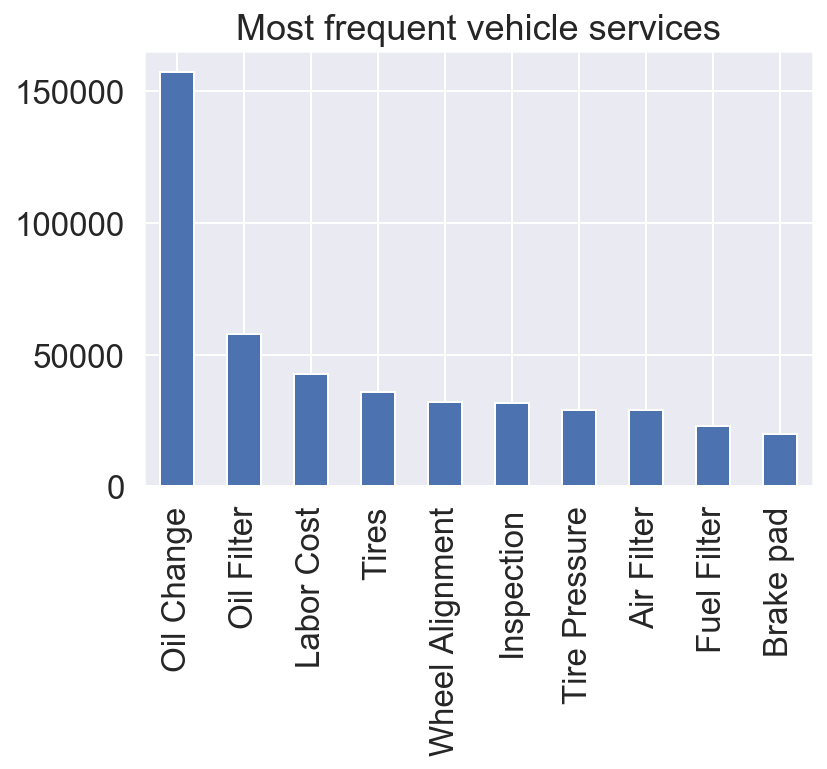

In [10]:
## Looking for the most frequent vehicle service
ax, fig = plt.subplots()
df.service.value_counts().head(10).plot('bar')
plt.xticks(range(10), ['Oil Change', 'Oil Filter', 'Labor Cost', 'Tires', 'Wheel Alignment', 'Inspection', 'Tire Pressure', 'Air Filter', 'Fuel Filter', 'Brake pad'])
plt.title('Most frequent vehicle services');

In [11]:
## Subsetting the data by 'Troca de Óleo' (Oil change) - most frequent service
df2 = df[df['service'] == 'Troca de Óleo'].copy()

In [12]:
## Checking for duplicates
len(df2[df2.duplicated() == True])

2315

In [13]:
## We can see that there are a lot of duplicates entries- Dropping the duplicates
df2 = df2.drop_duplicates()

In [14]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 154840 entries, 0 to 881614
Data columns (total 18 columns):
odometer          154840 non-null int64
date              154840 non-null object
service_id        154840 non-null int64
service           154840 non-null object
vehicle_id        154840 non-null int64
vehicle_type      154840 non-null int64
brand             154502 non-null float64
vehicle_year      153171 non-null float64
model             154829 non-null object
fuel_type         154840 non-null int64
fuel_volume       154840 non-null float64
fuel_volume2      147999 non-null float64
distance_unity    149864 non-null float64
currency          154840 non-null object
language_         154840 non-null object
country           154840 non-null object
latitude          128944 non-null float64
longitude         128944 non-null float64
dtypes: float64(7), int64(5), object(6)
memory usage: 22.4+ MB


### Cleaning the vehicle_year column

In [15]:
## The vehicle_year variable has majority of number zero.
df2.vehicle_year.value_counts().head()

0.0       61457
2012.0     9045
2011.0     8464
2013.0     8463
2014.0     7844
Name: vehicle_year, dtype: int64

In [16]:
df2.model.head(10)

0                        CORSA
2                         1300
4                  Corsa Sedan
7                          Jlx
12                         1.4
14                         Fox
17                      Gol G4
18                 Authentique
22    Cobalt LTZ 1.4 2013/2014
24                      Fusion
Name: model, dtype: object

In [17]:
## Some of the users input the vehicle year on the model name - I am extracting the year from the model (whenever
## possible):
df2['year_extract'] = df2.model.str.extract(r"(\d\d\d\d)", expand=True)

In [18]:
## Transforming the extracted year column to numeric
df2['year_extract'] = pd.to_numeric(df2.year_extract)

In [19]:
## Creating a list with the extracted years and vehicle_years (to replace the zeroes with the extracted year):
year = []
for index, row in df2.iterrows():
    if row['vehicle_year'] == 0:
        year.append(row['year_extract'])
    else:
        year.append(row['vehicle_year'])



In [20]:
## Creating a new 'year' column
df2['year'] = year

In [24]:
## Checking the new year column
df2[(df2.vehicle_year == 0)][['model', 'vehicle_year', 'year_extract', 'year']].head()

,model,vehicle_year,year_extract,year
0,CORSA,0.0,NaN,NaN
22,Cobalt LTZ 1.4 2013/2014,0.0,2013.0,2013.0
24,Fusion,0.0,NaN,NaN
26,CG TITAN ES 150,0.0,NaN,NaN
32,Clio,0.0,NaN,NaN


In [25]:
df2.year.describe()

count    9.611200e+04
mean     2.683571e+03
std      1.122700e+05
min      1.000000e+00
25%      2.008000e+03
50%      2.011000e+03
75%      2.014000e+03
max      2.010201e+07
Name: year, dtype: float64

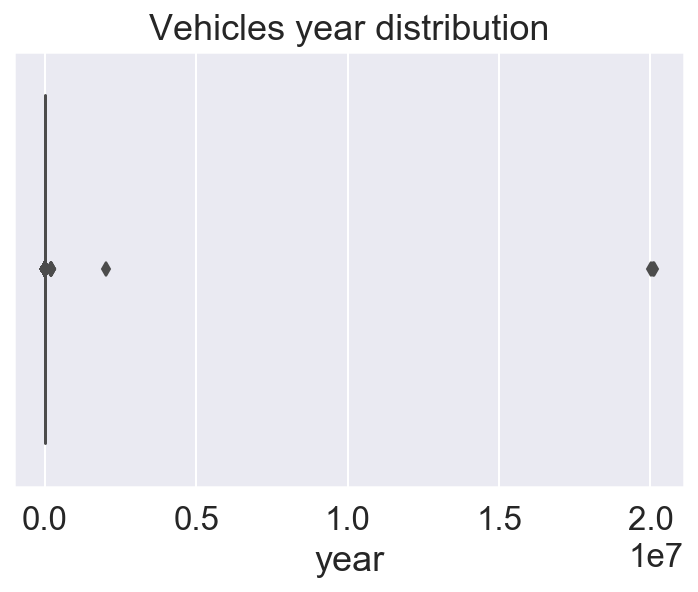

In [26]:
sns.boxplot(df2.year)
plt.title('Vehicles year distribution');

In [27]:
## We can see that the years for the vehicles are inputed in different formats (e.g, some users use 14 whereas others
## use 2014) - I am unifying those values

df2['year'] = df2.year.apply(lambda x: x+1900 if x in np.arange(30, 100) else x+2000 if x in np.arange(1, 20) else x)

In [28]:
## Looking at the description of the year column we can also see unreasonable numbers for year, so I am setting a 
## range from 1930 to 2020

df2 = df2[(df2.year > 1930) & (df2.year < 2020)].copy()

In [29]:
len(df2)

94726

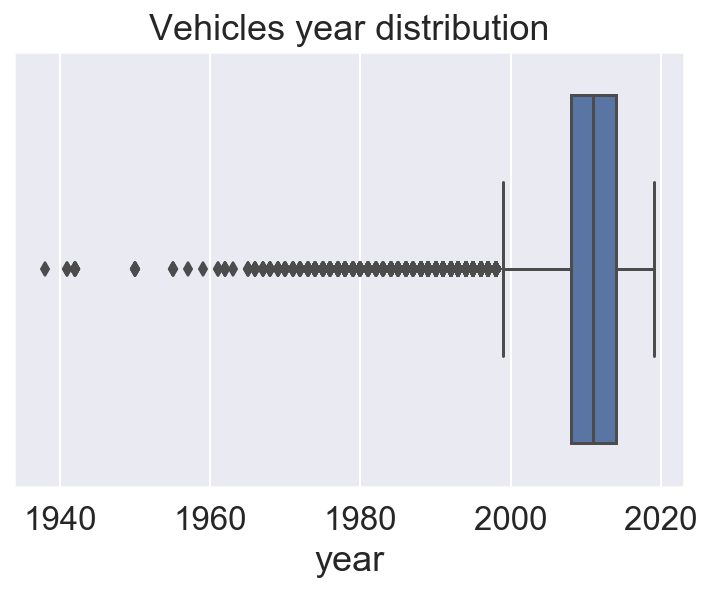

In [30]:
sns.boxplot(df2.year)
plt.title('Vehicles year distribution');

### Cleaning the fuel_volume variable

Some vehicles have 2 tank fuels (frequently with different sizes) - I am making the first column (fuel_volume) the main tank  - meaning the compartment with higher fuel volume.

In [31]:
def f_vol(row):
    if row['fuel_volume'] <= row['fuel_volume2']:
        val = row['fuel_volume2']
    else:
        val = row['fuel_volume']
    return val   

In [32]:
df2['fuel_volume'] = df2.apply(f_vol, axis=1)

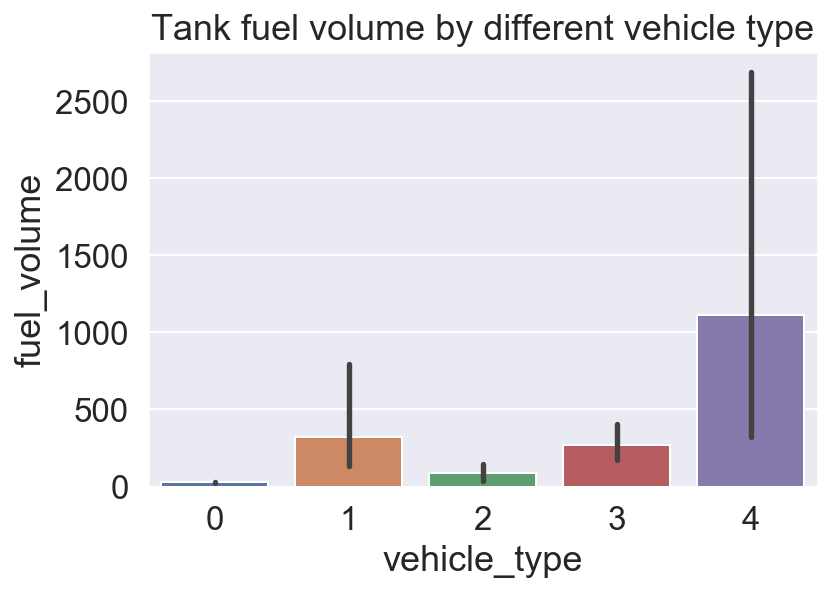

In [33]:
sns.barplot(x='vehicle_type', y='fuel_volume', data=df2)
plt.title('Tank fuel volume by different vehicle type');

In [34]:
## Vehicle type equal zero is a non-classified vehicle - I am dropping those values
df2 = df2[df2.vehicle_type != 0].copy()

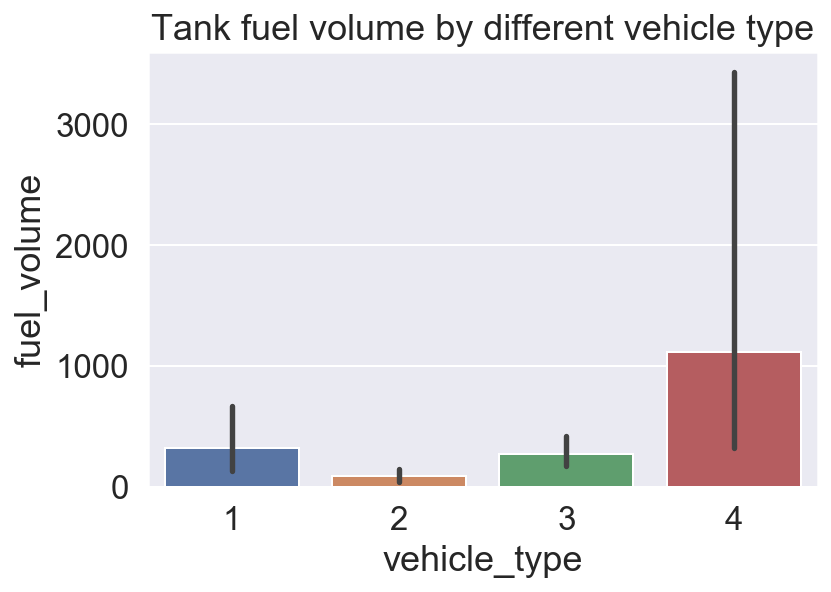

In [35]:
sns.barplot(x='vehicle_type', y='fuel_volume', data=df2)
plt.title('Tank fuel volume by different vehicle type');

In [36]:
df2.fuel_volume.describe()

count    9.460600e+04
mean     2.220495e+02
std      2.823365e+04
min      5.000000e-01
25%      1.400000e+01
50%      4.000000e+01
75%      5.000000e+01
max      8.555792e+06
Name: fuel_volume, dtype: float64

In [37]:
## We can see that there are some values for fuel tank volume that are not accurate for a car or motorcycle, like 0.5 
## or high values like 855,792 (that is probably in milliliters instead of liters)


In [38]:
## Transforming the fuel volumes that are in milliliters to liters
df2['fuel_volume'] = df2.fuel_volume.apply(lambda x: x/1000 if x >= 1000 else x)

In [39]:
## Keeping just a plausible range for fuel volume values
df2 = df2[~(df2['fuel_volume'] > 130) & ~(df2['fuel_volume'] < 8)]

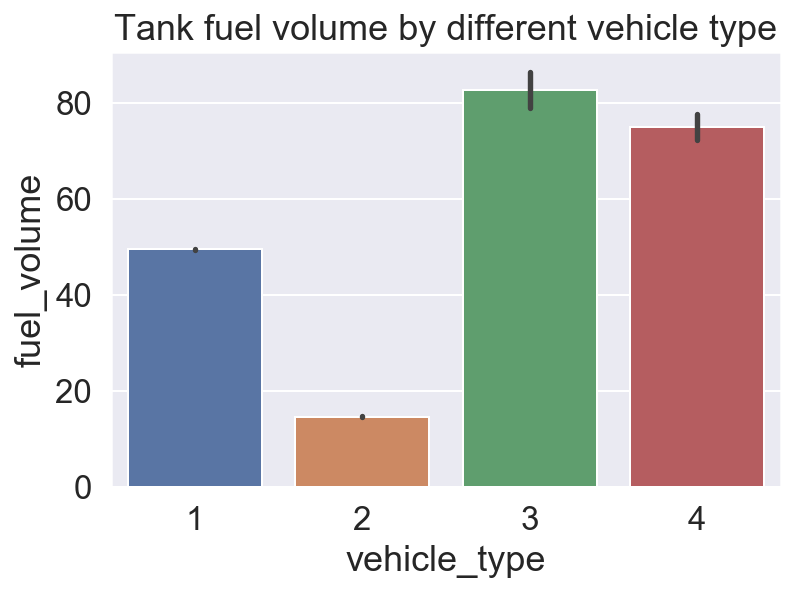

In [40]:
sns.barplot(x='vehicle_type', y='fuel_volume', data=df2)
plt.title('Tank fuel volume by different vehicle type');

### Cleaning the odometer readings

The difference in the odometer readings between services is going to be my target variable

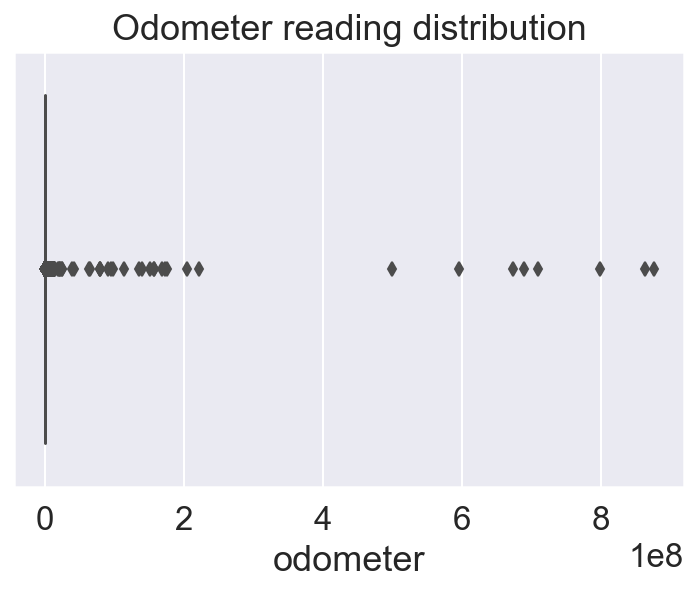

In [41]:
sns.boxplot(df2.odometer)
plt.title('Odometer reading distribution')
plt.show()

In [42]:
df2.odometer.describe()

count    8.901900e+04
mean     1.853663e+05
std      7.154204e+06
min      0.000000e+00
25%      3.510000e+04
50%      6.658000e+04
75%      1.089925e+05
max      8.759010e+08
Name: odometer, dtype: float64

In [43]:
## We can see that the kilometers on the odometer reader have great variation - considering that this parameter is an
## input from the users and that oil change would not be necessary for vehicles with 0 (zero) kilometers and is very
## unlikely that a car have more than 500k km, I'm dropping those extreme values:

In [44]:
df2 = df2[(df2['odometer'] > 1000) & (df2['odometer'] < 500000)]

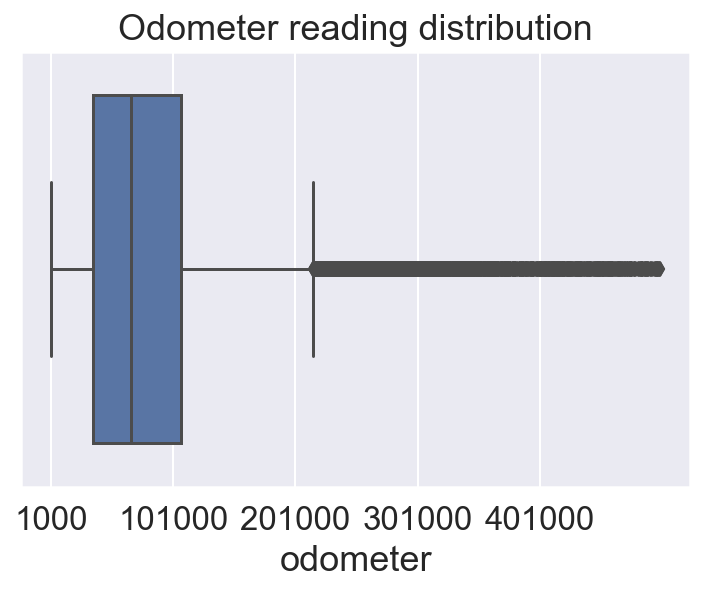

In [45]:
sns.boxplot(df2.odometer)
plt.title('Odometer reading distribution')
plt.xticks(range(1000, 500000, 100000))
plt.show()

### Adding the fuel variable

Another possible predictor variable is the most frequent fuel used by the car. To do so, I accessed the fuel data from the postgreSQL system

In [46]:
fuel = pd.read_csv('fuel.csv')

In [47]:
fuel.shape

(6188820, 5)

In [48]:
fuel.columns = ['user_id', 'vehicle_id', 'fuel_id', 'fuel_name', 'currency']

In [49]:
fuel.head()

,user_id,vehicle_id,fuel_id,fuel_name,currency
0,642369,600990,2605022,GNV,BRL
1,9986,10812,41813,Etanol,BRL
2,384673,866709,1331820,Gas. Comum,BRL
3,1174345,1252957,6153984,Etanol,BRL
4,2140051,3132388,13492894,Etanol,BRL


In [50]:
## Keeping just data from Brazil using the same criteria as before (currency)
fuel = fuel[(fuel.currency == 'BRL') | (fuel.currency == 'pt_BR')]

In [51]:
fuel.shape

(6188565, 5)

In [52]:
fuel.fuel_name.value_counts().head(20)

Gas. Comum            2574163
Etanol                1520876
Gas. Aditivada         928913
GNV                    693966
Diesel                 173687
Gasoline                49278
Ethanol                 24023
Diesel S10              16233
Gasolina                12951
Gasolina Comum          11632
Gnv                     10876
Gas. Premium             9664
Etanol Aditivado         9093
Gas Premium              8471
Gasolina Aditivada       5648
Gás Natural              4668
Etanol Comum             4141
Gas. V-Power             3839
CNG                      3639
LPG                      3337
Name: fuel_name, dtype: int64

In [53]:
## Because the fuel name is inputed by the user, we can see that there's lots of different entries
len(fuel.fuel_name.unique())

3960

In [54]:
## Trying to group the fuels by name

fuels_list = ['Gas. Comum', 'Gas. Aditivada', 'Gas Premium', 'Gas Aditivada', 'Gas Comum', 'Etanol', 'Gás', 'GNV', 'Vpower', 'V power', 'Premium', 'Aditivada', 'adtv',
             'Podium', 'Alcool', 'Álcool', 'Octapro', 'Diesel', 'Pódium', 'DT', 'Dtclean', 'LPG', 'CNG', 'Elétrico', 'Eletrico',
             'V-power', 'Ethanol', 'Comum', 'Gasolina', 'Gasoline', 'Gazolina', 'Gas. Normal', 'Normal', 'Gas Normal', 'Grid', 'S10', 'Disel', 'Comun', 'Gas', 'Podiun', 'S 10', 'S-10',
             'V- power', 'Power', 'Super', 'Dizel', 'Bioalcohol']

fuel['fuels'] = fuel.fuel_name.str.extract('({})'.format('|'.join(fuels_list)),flags=re.IGNORECASE, expand=False).str.lower().map({'gas. comum': 'gasoline', 'gas. aditivada': 'premium gasoline', 
                                                                                                                             'gas premium': 'premium gasoline', 'gas aditivada': 'premium gasoline',
                                                                                                                             'gas comum': 'gasoline', 'etanol': 'ethanol', 'gás': 'ngv', 'gnv': 'ngv',
                                                                                                                             'vpower': 'premium gasoline' , 'v power': 'premium gasoline', 'premium': 'premium gasoline',
                                                                                                                             'aditivada': 'premium gasoline', 'adtv': 'premium gasoline','podium': 'premium gasoline',
                                                                                                                             'alcool': 'ethanol', 'álcool': 'ethanol', 'octapro': 'premium gasoline', 'diesel': 'diesel',
                                                                                                                             'pódium': 'premium gasoline', 'dt': 'premium gasoline', 'dtclean': 'premium gasoline',
                                                                                                                             'lpg': 'lpg', 'cng':'ngv', 'elétrico': 'electric', 'eletrico': 'electric', 'v-power': 'premium gasoline',
                                                                                                                             'ethanol': 'ethanol', 'comum': 'gasoline', 'gasolina': 'gasoline', 'gasoline': 'gasoline',
                                                                                                                             'gazolina': 'gasoline', 'gas. normal': 'gasoline', 'normal':'gasoline', 
                                                                                                                              'gas normal': 'gasoline', 'grid': 'premium gasoline', 's10':'diesel', 'disel': 'diesel', 'dizel': 'diesel',
                                                                                                                             'comun': 'gasoline', 'gas': 'ngv', 's 10': 'diesel', 'podiun': 'premium gasoline',
                                                                                                                             's-10': 'diesel', 'v- power': 'premium gasoline', 'power': 'premium gasoline',
                                                                                                                             'super': 'premium gasoline', 'bioalcohol': 'ethanol'}).fillna(fuel.fuel_name.str.lower())



In [55]:
len(fuel.fuels.unique())

1607

In [56]:
## Although it has lowered, there is still a large number of unique entries for fuel names,
## so I'm subsetting to keep just the most frequent fuels

In [57]:
fuel.fuels.value_counts().head(10)

gasoline            2680818
ethanol             1571545
premium gasoline     966020
ngv                  749558
diesel               201989
lpg                    3337
electric               2772
gnc                     622
e98                     519
não informado           484
Name: fuels, dtype: int64

In [58]:
fuels_ = ['gasoline', 'ethanol', 'premium gasoline', 'ngv', 'diesel', 'lpg', 'electric']

In [59]:
fuel['fuels'] = fuel.fuels.apply(lambda x: 'else' if x not in fuels_ else x)

In [60]:
fuel.fuels.value_counts()

gasoline            2680818
ethanol             1571545
premium gasoline     966020
ngv                  749558
diesel               201989
else                  12526
lpg                    3337
electric               2772
Name: fuels, dtype: int64

In [61]:
## I am subsetting by vehicle_id and fuels to check the most frequent fuels by vehicle

In [62]:
df_fuel = pd.DataFrame(fuel.groupby(['vehicle_id'])['fuels'].value_counts())

In [65]:
df_fuel.columns = ['fuel_counts']

In [66]:
df_fuel.head()

fuel_counts
vehicle_id fuels                        
1          gasoline                  426
           premium gasoline           18
2          gasoline                  114
           premium gasoline            3
3          gasoline                  126

In [67]:
## Sortting the values by vehicle_id and fuel_counts

df_fuel = df_fuel.sort_values(by=['vehicle_id', 'fuel_counts'], ascending=True)

In [68]:
## Create a list of unique vehicles IDs to make a dictionary of vehicle and its most frequent used fuel
uniques_ = list(fuel.vehicle_id.unique())

In [69]:
fuel_dict = {}
for i in uniques_:
    fuel_dict[i] = df_fuel.loc[i].iloc[-1:].index[0]

In [70]:
## Checking most frequent fuel name of vehicle_id 4420
fuel_dict[4420]

'gasoline'

In [71]:
## Creating a new column at the original data frame with the fuel by vehicle_id (mapping by the vehicle ID)
df2['fuel'] = df2.vehicle_id.map(fuel_dict)

In [72]:
df2.head()

,odometer,date,service_id,service,vehicle_id,vehicle_type,brand,vehicle_year,model,fuel_type,...,fuel_volume2,distance_unity,currency,language_,country,latitude,longitude,year_extract,year,fuel
2,39340,2016-03-04 08:13:01,1291925,Troca de Óleo,39462,1,283.0,1976.0,1300,1,...,NaN,NaN,pt_BR,pt_BR,Brazil,NaN,NaN,1300.0,1976.0,premium gasoline
4,165940,2016-07-09 13:22:46,14057354,Troca de Óleo,416001,1,61.0,2003.0,Corsa Sedan,1,...,NaN,NaN,pt_BR,pt_BR,Brazil,NaN,NaN,NaN,2003.0,NaN
7,177600,2016-05-21 06:36:07,10990741,Troca de Óleo,323649,1,258.0,1997.0,Jlx,1,...,NaN,NaN,pt_BR,pt_BR,Brazil,NaN,NaN,NaN,1997.0,ngv
12,85948,2016-04-26 17:28:50,4820864,Troca de Óleo,141784,1,61.0,2009.0,1.4,1,...,0.0,1.0,BRL,pt_BR,Brazil,-23.623496,-46.541333,NaN,2009.0,ethanol
14,107623,2016-05-31 16:24:26,11340496,Troca de Óleo,333894,1,283.0,2011.0,Fox,1,...,NaN,NaN,pt_BR,pt_BR,Brazil,NaN,NaN,NaN,2011.0,NaN


### Creating the target variable - Difference in odometer readings

Vehicles have multiple entries for every service.
To create my target (that will be the odometer reading difference between services) I will sort the values and do the odometer reading difference.
The goal is to try to predict in how many kilometers each service is done.

In [74]:
df2 = df2.sort_values(by=['vehicle_id', 'odometer'])

In [75]:
df2['odometer_diff'] = df2.groupby('vehicle_id')['odometer'].diff()

In [76]:
## Vehicles have multiple entries for every service.
## I am creating a dictionary with the mean difference on the odometer reading and just keeping one entry for odometer 
## reading difference per vehicle:
uniques = list(df2.vehicle_id.unique())

In [77]:
## Creating a dictionary with vehicle_id and the mean difference on odometer reading

dict_mean = {}
for i in uniques:
    dict_mean[i] = df2[df2['vehicle_id'] == i].odometer_diff.mean()
    

In [78]:
## Creating a dataframe with just one entry per vehicle
df_diff = pd.DataFrame()
for i in uniques:
    try:
        x = df2[df2['vehicle_id'] == i].iloc[-1:]
        df_diff = pd.concat([df_diff, x], axis=0)
        
    except:
        pass

In [79]:
## Creating the mean difference column with the dictionary

df_diff['diff_mean'] = df_diff.vehicle_id.map(dict_mean)

In [80]:
## Saving the dataframe into a csv file
df_diff.to_csv('drivvo_clean.csv')

In [81]:
df_diff = pd.read_csv('drivvo_clean.csv', index_col=0)

In [82]:
df_diff.shape

(36057, 23)

In [83]:
## Vehicles that have just one entry would have null value for the odometer reading difference
## I am dropping the null values

df_diff = df_diff[~df_diff.odometer_diff.isnull()]

### Cleaning the brands

I am using the brand of the vehicle as another predictor.

In [84]:
len(df_diff.brand.unique())

67

In [85]:
df_diff.brand.value_counts().tail(10)

275.0    1
244.0    1
13.0     1
100.0    1
289.0    1
315.0    1
121.0    1
74.0     1
77.0     1
295.0    1
Name: brand, dtype: int64

In [86]:
## We can see that there are a lot of brands with just one vehicle registered. I am dropping the brands with less than
## 20 entries

In [87]:
brand_counts = df_diff.brand.value_counts()

In [88]:
len(brand_counts[brand_counts > 20])

26

In [89]:
brands = brand_counts[brand_counts > 20].index
brands

Float64Index([127.0,  61.0,  99.0, 290.0, 283.0, 126.0, 101.0, 230.0, 258.0,
              267.0, 203.0, 216.0, 110.0, 130.0,  63.0, 191.0,  73.0, 150.0,
              152.0, 186.0, 149.0,  36.0, 140.0, 119.0,  23.0,  60.0],
             dtype='float64')

In [90]:
df_diff = df_diff[df_diff.brand.isin(brands)]

In [91]:
df_diff.shape

(15158, 23)

### Some More Cleaning and Plotting - Data Visualization

#### Target

My target is going to be the mean difference on the odometer reading between services

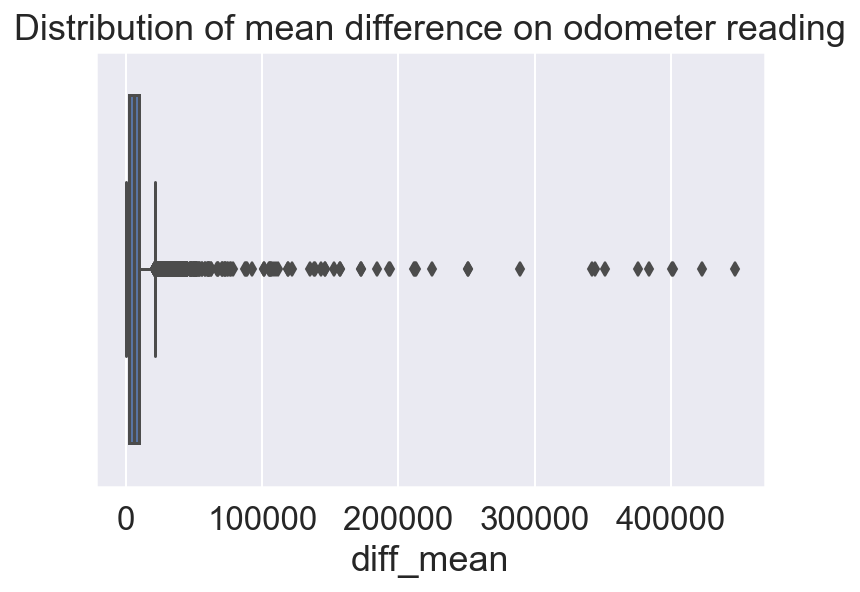

In [92]:
sns.boxplot(df_diff.diff_mean)
plt.title('Distribution of mean difference on odometer reading')
plt.show()

In [93]:
## We can see a very skewed distribution on the target variable. I am dropping the outliers
## Also, I am considering that it's not possible to have a mean difference of zero on the odometer reading between 
## services

In [94]:
df_diff = df_diff[(df_diff['diff_mean'] > df_diff.diff_mean.quantile(0.05))& \
                    (df_diff['diff_mean'] < df_diff.diff_mean.quantile(0.95))]

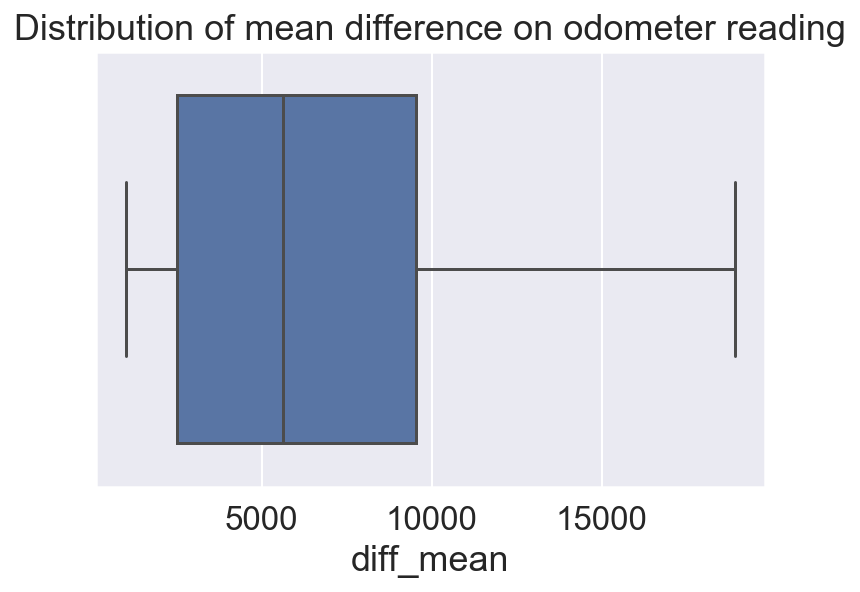

In [95]:
sns.boxplot(df_diff.diff_mean)
plt.title('Distribution of mean difference on odometer reading')
plt.show()

#### Predictors

As predictors I am going to use the odometer reading, vehicle type, brand of the vehicle, fuel tank volume, the year of the vehicle and fuel most frequently used.

In [96]:
df_diff.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13642 entries, 704091 to 78844
Data columns (total 23 columns):
odometer          13642 non-null int64
date              13642 non-null object
service_id        13642 non-null int64
service           13642 non-null object
vehicle_id        13642 non-null int64
vehicle_type      13642 non-null int64
brand             13642 non-null float64
vehicle_year      13642 non-null float64
model             13641 non-null object
fuel_type         13642 non-null int64
fuel_volume       13642 non-null float64
fuel_volume2      13241 non-null float64
distance_unity    13273 non-null float64
currency          13642 non-null object
language_         13642 non-null object
country           13642 non-null object
latitude          11566 non-null float64
longitude         11566 non-null float64
year_extract      1072 non-null float64
year              13642 non-null float64
fuel              12961 non-null object
odometer_diff     13642 non-null float64
di

<b> Fuel Tank Volume </b>

In [97]:
## Dropping the fuel null values 
df_diff = df_diff[df_diff.fuel.notnull()]

In [98]:
## Creating a DataFrame just with the variables I am going to use on my models.

df_final = df_diff[['odometer', 'vehicle_type', 'brand','fuel_volume', 'year','fuel', 'diff_mean']]

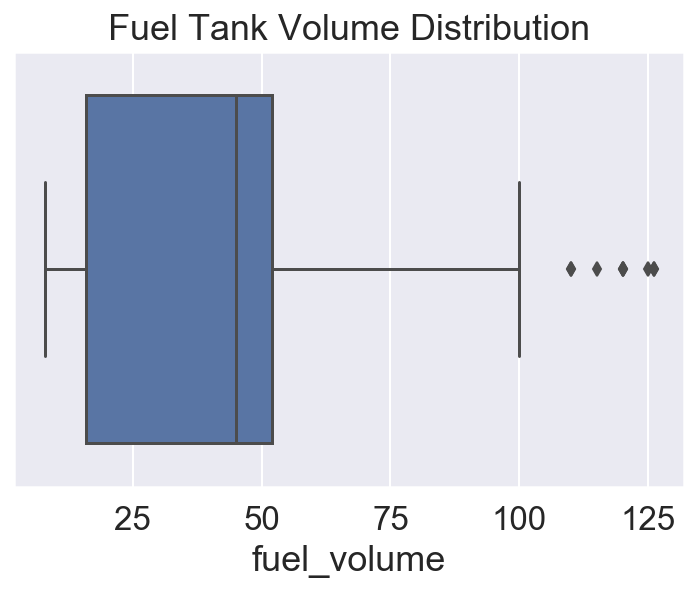

In [99]:
sns.boxplot(df_final.fuel_volume)
plt.title('Fuel Tank Volume Distribution');

<b> Vehicle Type </b>

In [100]:
df_final.groupby('vehicle_type').vehicle_type.describe()

,count,mean,std,min,25%,50%,75%,max
vehicle_type,,,,,,,,
1,8343.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
2,4584.0,2.0,0.0,2.0,2.0,2.0,2.0,2.0
3,14.0,3.0,0.0,3.0,3.0,3.0,3.0,3.0
4,20.0,4.0,0.0,4.0,4.0,4.0,4.0,4.0


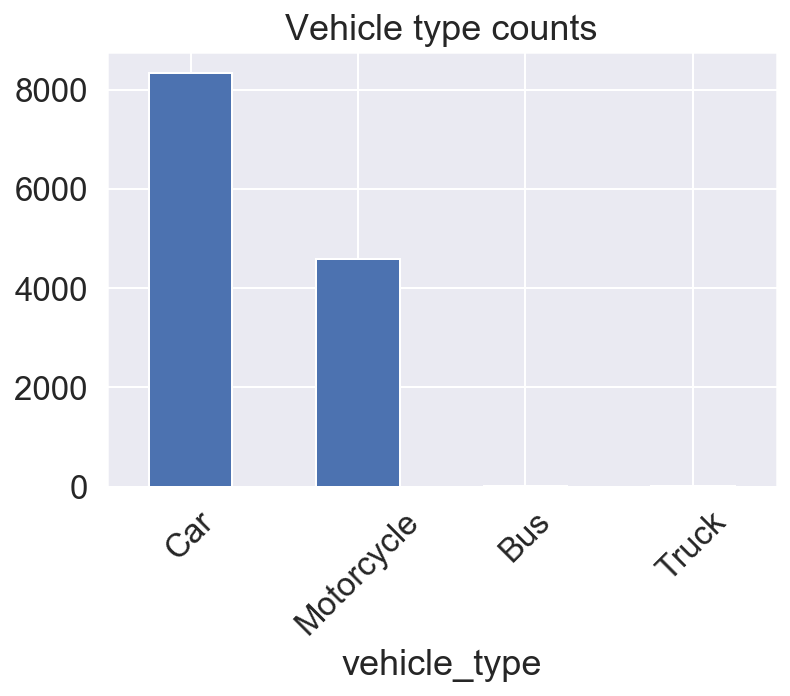

In [101]:
df_final.groupby('vehicle_type').vehicle_type.count().plot('bar')
plt.title('Vehicle type counts')
plt.xticks(range(4), ['Car', 'Motorcycle', 'Bus', 'Truck'], rotation=45);

In [102]:
## We can see that vehicle types 3 (bus) and 4 (truck) sum up to only 60 entries. I am just keeping vehicle types
## 1(car) and 2 (motorcycle) for the modelling

In [103]:
df_final = df_final[(df_final.vehicle_type != 3) & (df_final.vehicle_type !=4)]

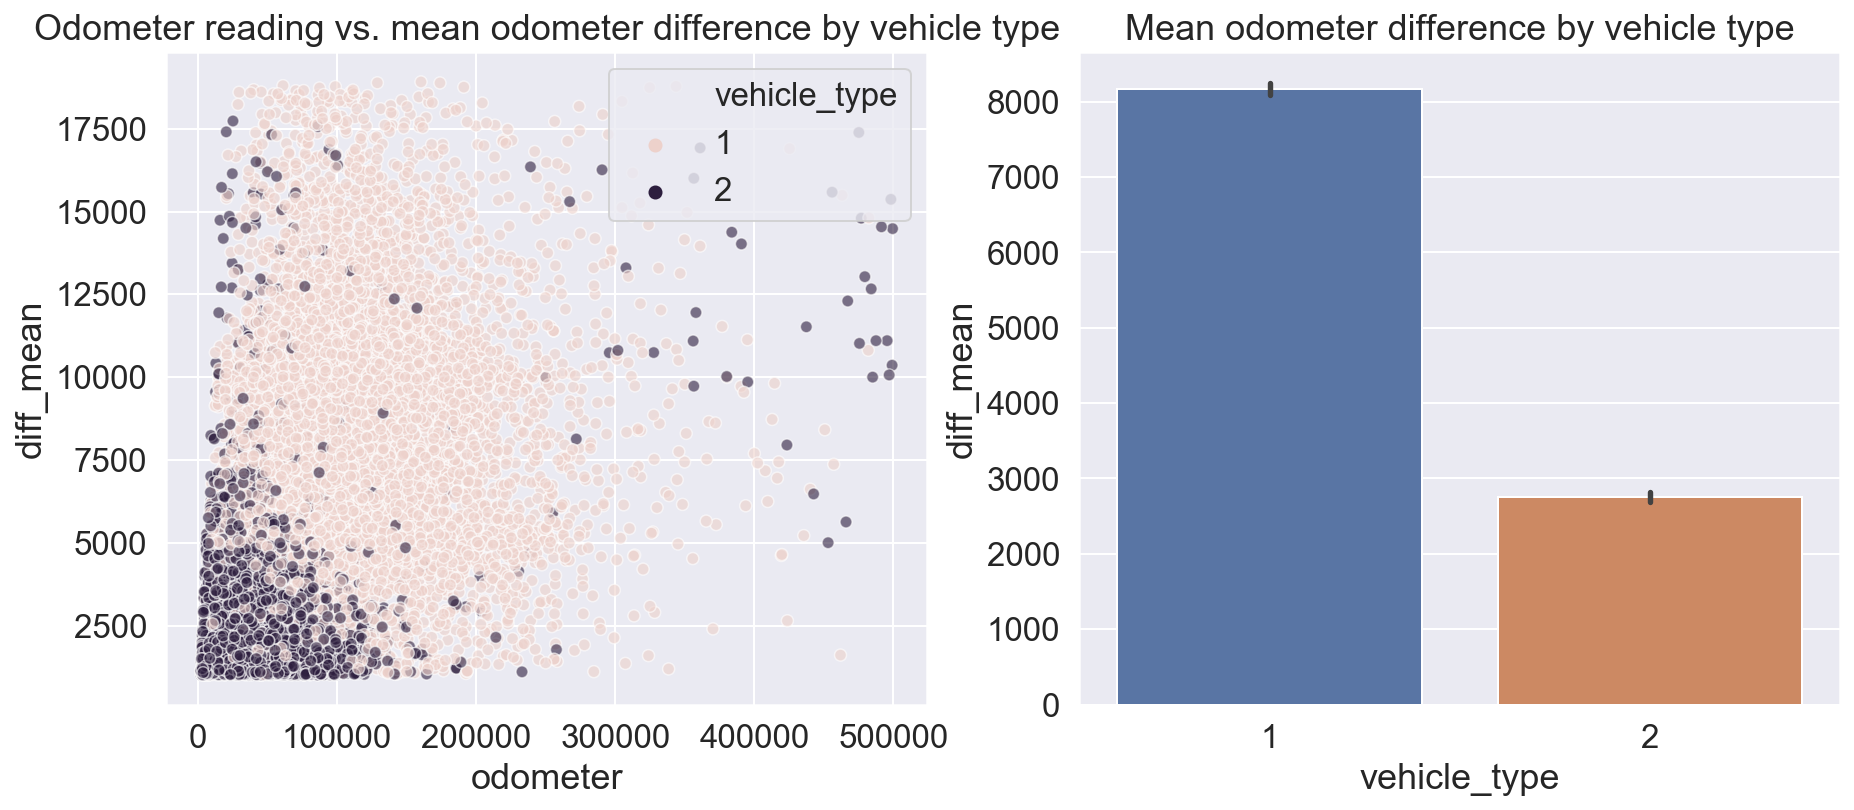

In [104]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,6))

sns.scatterplot(x= df_final.odometer, y=df_final.diff_mean, hue=df_final.vehicle_type, alpha=0.6, ax=ax1, legend='full')
ax1.set_title('Odometer reading vs. mean odometer difference by vehicle type')

sns.barplot(x= df_final.vehicle_type, y= df_final.diff_mean, ax=ax2)
ax2.set_title('Mean odometer difference by vehicle type')

plt.show()


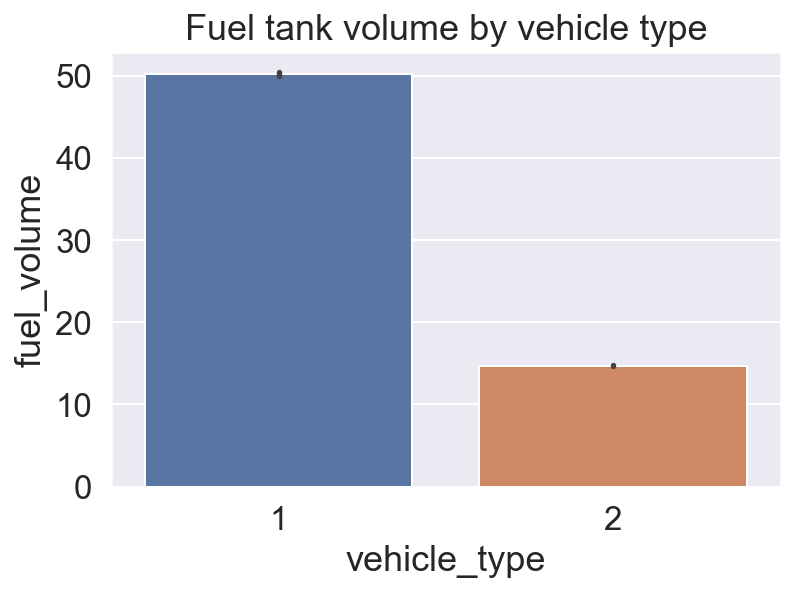

In [108]:
fig, ax = plt.subplots()
sns.barplot(x='vehicle_type', y='fuel_volume', data=df_final)
plt.title('Fuel tank volume by vehicle type')
plt.show()

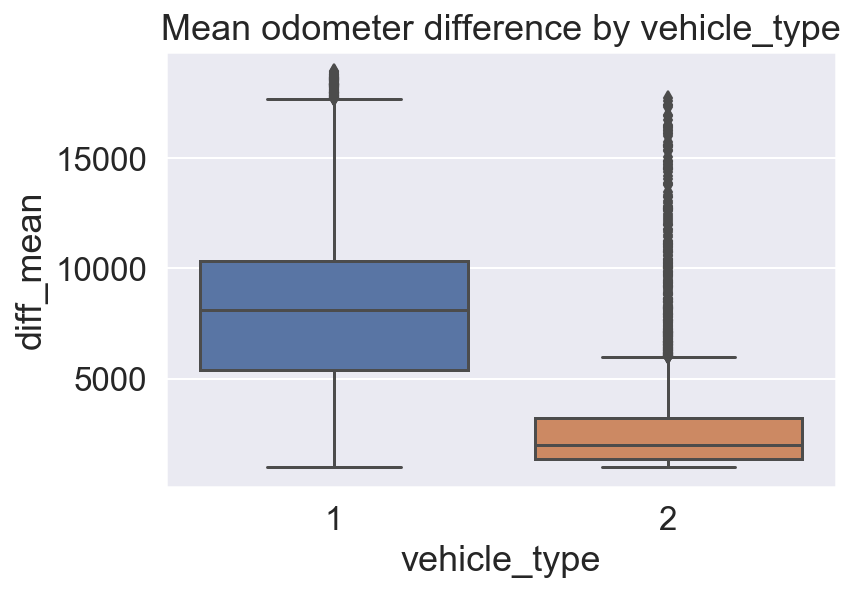

In [109]:
sns.boxplot(x = df_final.vehicle_type, y=df_final.diff_mean)
plt.title('Mean odometer difference by vehicle_type')
plt.show()

In [110]:
## We can see that there is a great amount of outliers for the mean odometer difference for vehicle type 2 (motorcycle)
## I am dropping those values using quantile

In [111]:
df_final = df_final[~((df_final.vehicle_type == 2) & (df_final.diff_mean > df_final[df_final.vehicle_type == 2].diff_mean.quantile(0.90)))]

In [112]:
df_final.shape

(12459, 7)

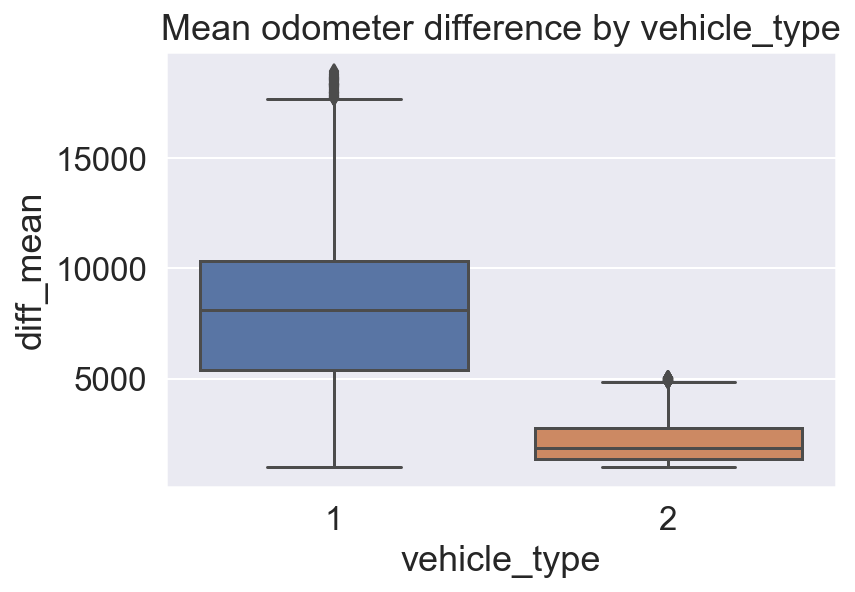

In [113]:
sns.boxplot(x = df_final.vehicle_type, y=df_final.diff_mean)
plt.title('Mean odometer difference by vehicle_type')
plt.show()

<b> Vehicle's year </b>

In [105]:
df_final.year.value_counts().tail(15)

1987.0    3
1976.0    3
1974.0    3
1973.0    3
1983.0    2
1970.0    2
1968.0    1
1972.0    1
1965.0    1
1969.0    1
1955.0    1
1980.0    1
1950.0    1
1966.0    1
1942.0    1
Name: year, dtype: int64

In [106]:
## We can see that vehicle's years less than 1976 have just few entries. I am dropping those entries
df_final = df_final[df_final.year > 1970]

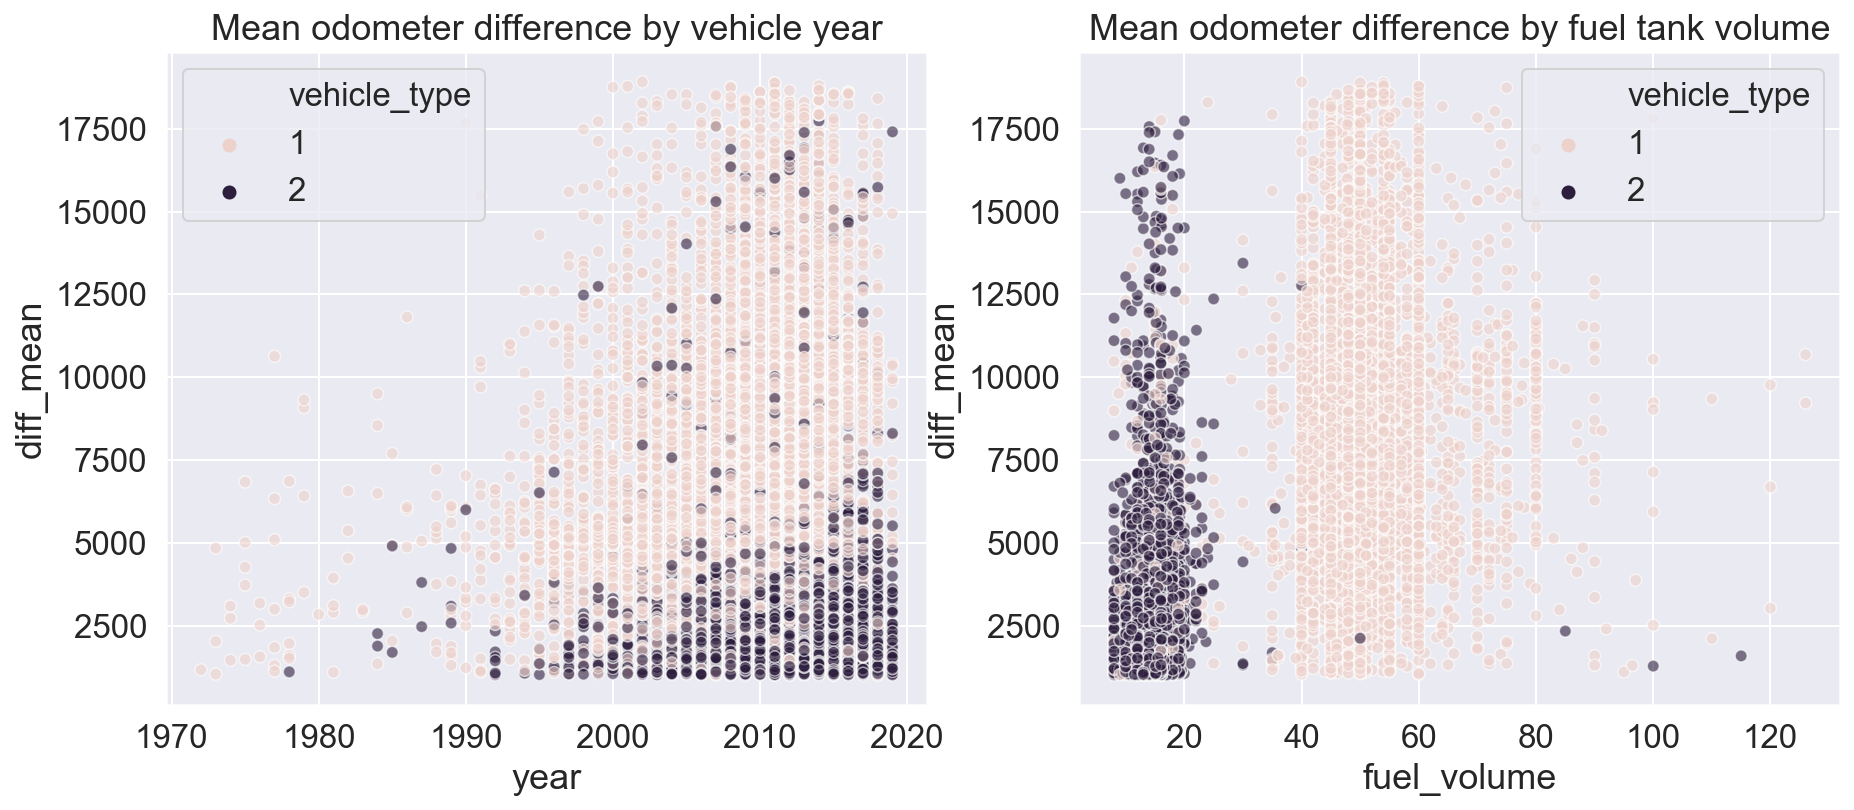

In [107]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,6))

sns.scatterplot(x= df_final.year, y=df_final.diff_mean, hue=df_final.vehicle_type, alpha=0.6, ax=ax1, legend='full')
ax1.set_title('Mean odometer difference by vehicle year')

sns.scatterplot(x= df_final.fuel_volume, y=df_final.diff_mean, hue=df_final.vehicle_type, alpha=0.6, ax=ax2, legend='full')
ax2.set_title('Mean odometer difference by fuel tank volume')

plt.show()

<b> Different types of fuel </b>

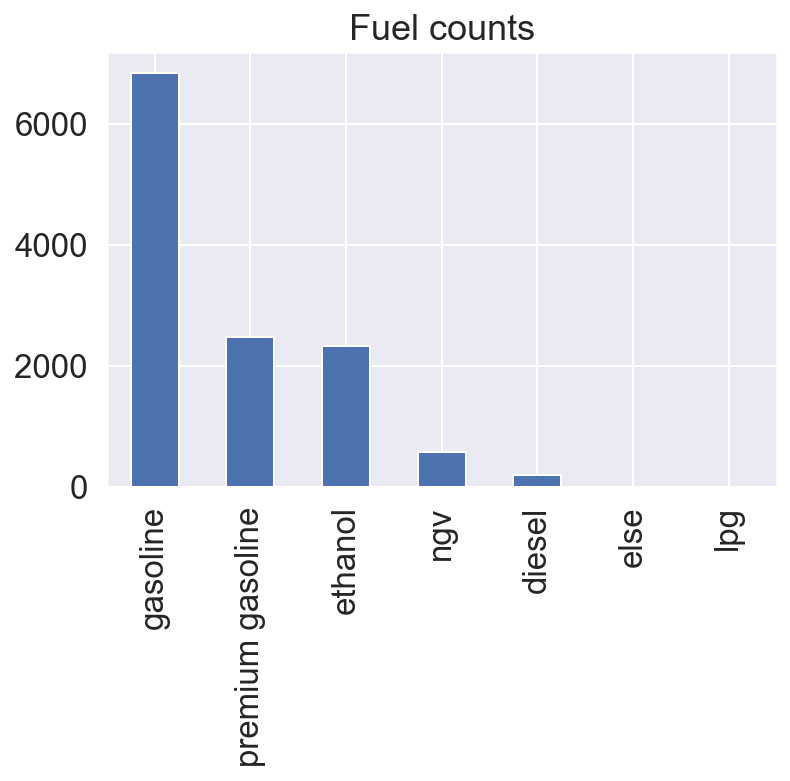

In [115]:
## Checking the most prevalent fuel types

df_final.fuel.value_counts().plot('bar')
plt.title('Fuel counts');

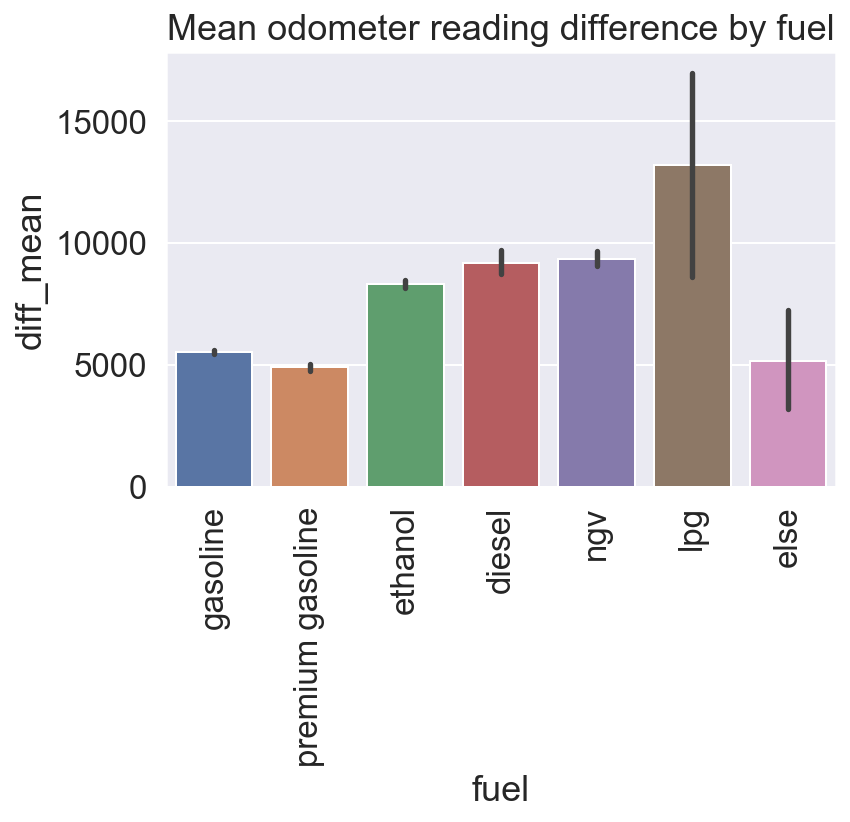

In [116]:
## Looking for the mean difference in odometer reading according to the fuel type

sns.barplot(x='fuel', y='diff_mean', data=df_final)
plt.title('Mean odometer reading difference by fuel')
plt.xticks(rotation=90);

In [117]:
df_final.groupby('fuel').fuel.describe().sort_values(by='count', ascending=False)

,count,unique,top,freq
fuel,,,,
gasoline,6842,1,gasoline,6842
premium gasoline,2484,1,premium gasoline,2484
ethanol,2330,1,ethanol,2330
ngv,587,1,ngv,587
diesel,203,1,diesel,203
else,9,1,else,9
lpg,4,1,lpg,4


In [118]:
## We can see that there is only few entries for 'else' and 'lpg' fuels - I am dropping them

df_final = df_final[(df_final.fuel != 'else') & (df_final.fuel != 'lpg')]

In [119]:
df_final.corr()

,odometer,vehicle_type,brand,fuel_volume,year,diff_mean
odometer,1.000000,-0.500814,-0.093765,0.493112,-0.459628,0.378399
vehicle_type,-0.500814,1.000000,0.172363,-0.878719,0.210759,-0.684455
brand,-0.093765,0.172363,1.000000,-0.151037,0.034757,-0.120140
fuel_volume,0.493112,-0.878719,-0.151037,1.000000,-0.169427,0.666282
year,-0.459628,0.210759,0.034757,-0.169427,1.000000,0.036760
diff_mean,0.378399,-0.684455,-0.120140,0.666282,0.036760,1.000000


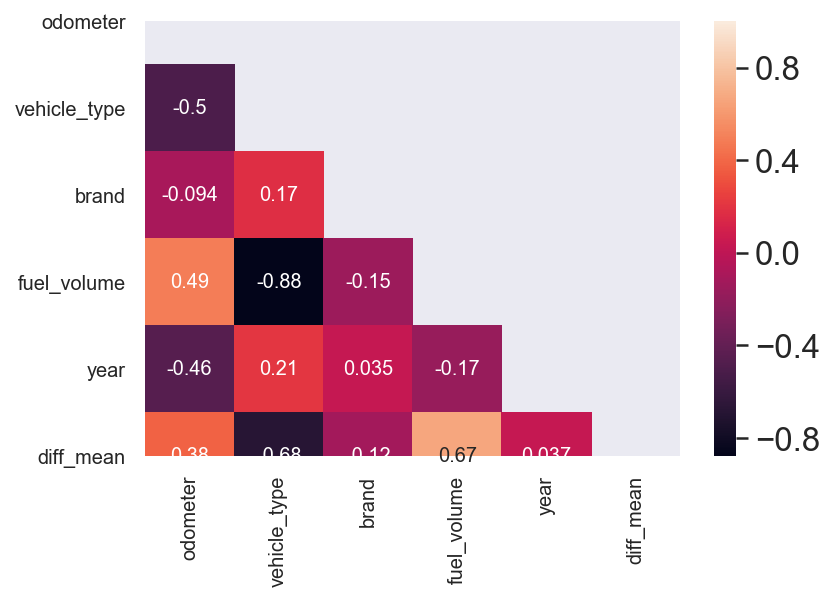

In [120]:
# Set the default matplotlib figure size:
fig, ax = plt.subplots()

# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(df_final.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Plot the heatmap with seaborn.
# Assign the matplotlib axis the function returns. This will let us resize the labels.
ax = sns.heatmap(df_final.corr(), mask=mask, annot=True, ax=ax)

# Resize the labels.
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=10)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=10)


# If you put plt.show() at the bottom, it prevents those useless printouts from matplotlib.
plt.show()

# Regression Models

In [121]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, BaggingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

#### Setting target and predictors

In [122]:
X = df_final[['odometer', 'brand', 'vehicle_type', 'fuel', 'fuel_volume', 'year']].copy()
y = df_final['diff_mean']

#### Preprocessing

In [123]:
## Dummifying predictors
X = pd.get_dummies(X, columns = ['brand', 'vehicle_type', 'fuel'], drop_first=True)

In [124]:
X.head()

,odometer,fuel_volume,year,brand_36.0,brand_60.0,brand_61.0,brand_63.0,brand_73.0,brand_99.0,brand_101.0,...,brand_230.0,brand_258.0,brand_267.0,brand_283.0,brand_290.0,vehicle_type_2,fuel_ethanol,fuel_gasoline,fuel_ngv,fuel_premium gasoline
704091,61383,50.0,2011.0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
271592,177340,79.0,2000.0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
852668,123293,42.0,2008.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
597360,4406,13.0,2014.0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,1,0,0
84869,7649,19.2,2015.0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,1,0,0


In [125]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [126]:
# Standardizing the data
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)

In [127]:
X_test = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)

### Linear Regression

In [128]:
# Running Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [129]:
lr_train = lr.score(X_train, y_train)
lr_test = lr.score(X_test, y_test)
lr_cv = cross_val_score(lr, X_train, y_train, cv=5).mean()

print('Linear regression train score:', lr_train)
print('Linear regression test score:', lr_test)
print('Linear regression CV score:', lr_cv)

Linear regression train score: 0.5493991377163734
Linear regression test score: 0.5503982248997619
Linear regression CV score: 0.5444652235856171


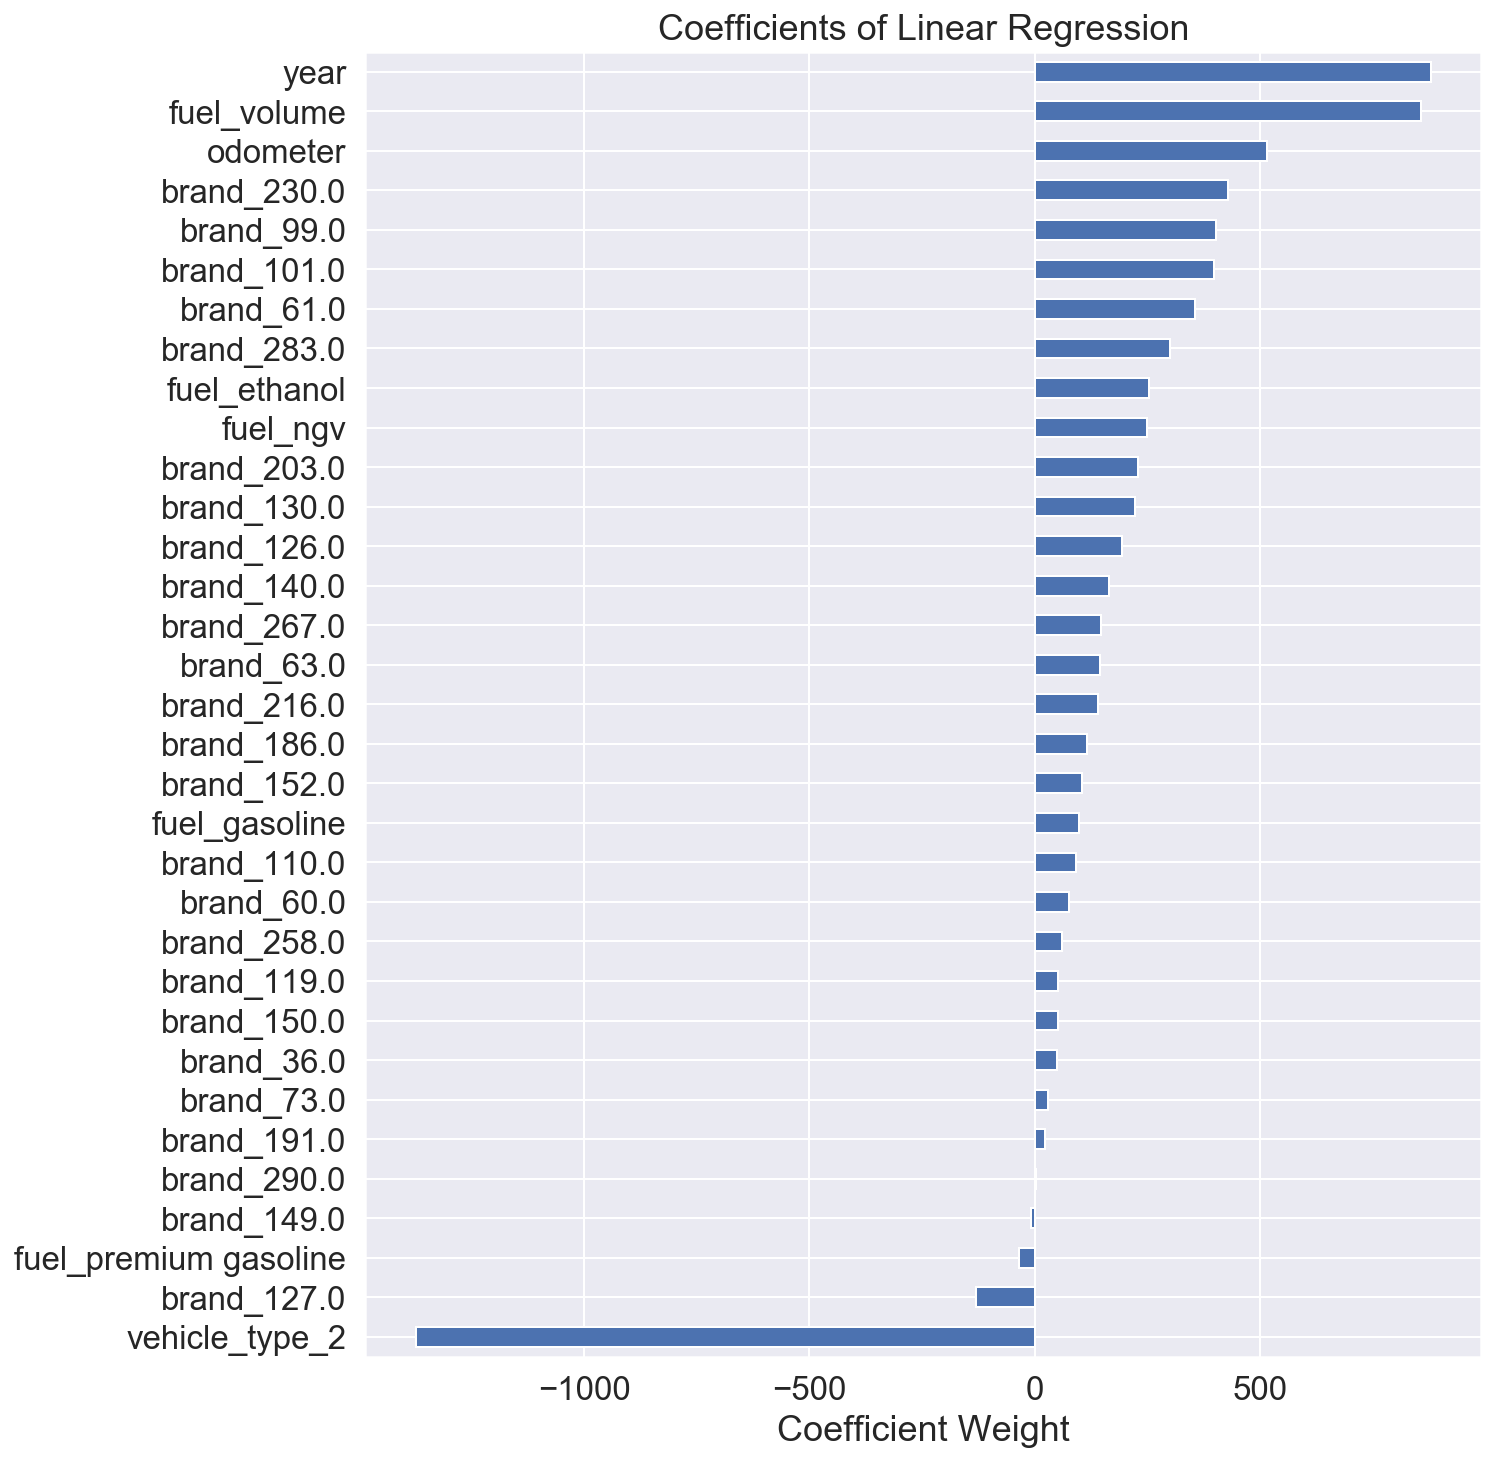

In [131]:
## Checking the positive coefficients of Linear regressioan

fig, ax = plt.subplots(figsize=(10,12))

lr_coef = pd.DataFrame(lr.coef_, index=X_train.columns,
                       columns=['coefficients'])

lr_coef.coefficients.sort_values().plot(kind='barh')

plt.title('Coefficients of Linear Regression')
plt.xlabel('Coefficient Weight');

#### Linear Regression with regularization

Running Linear Regression with regularization - Ridge and Lasso

#### Ridge

In [132]:
ridge_cv = RidgeCV(alphas=np.logspace(-5, 5, 20), cv=5)
ridge_cv.fit(X_train, y_train)

ridge_test = ridge_cv.score(X_test, y_test)
ridge_train = ridge_cv.score(X_train, y_train)

print('Best alpha:', ridge_cv.alpha_)
print('RidgeCV training score:', ridge_train)
print('RidgeCV test score:', ridge_test)


Best alpha: 69.51927961775606
RidgeCV training score: 0.5493367604405954
RidgeCV test score: 0.5503552977247856


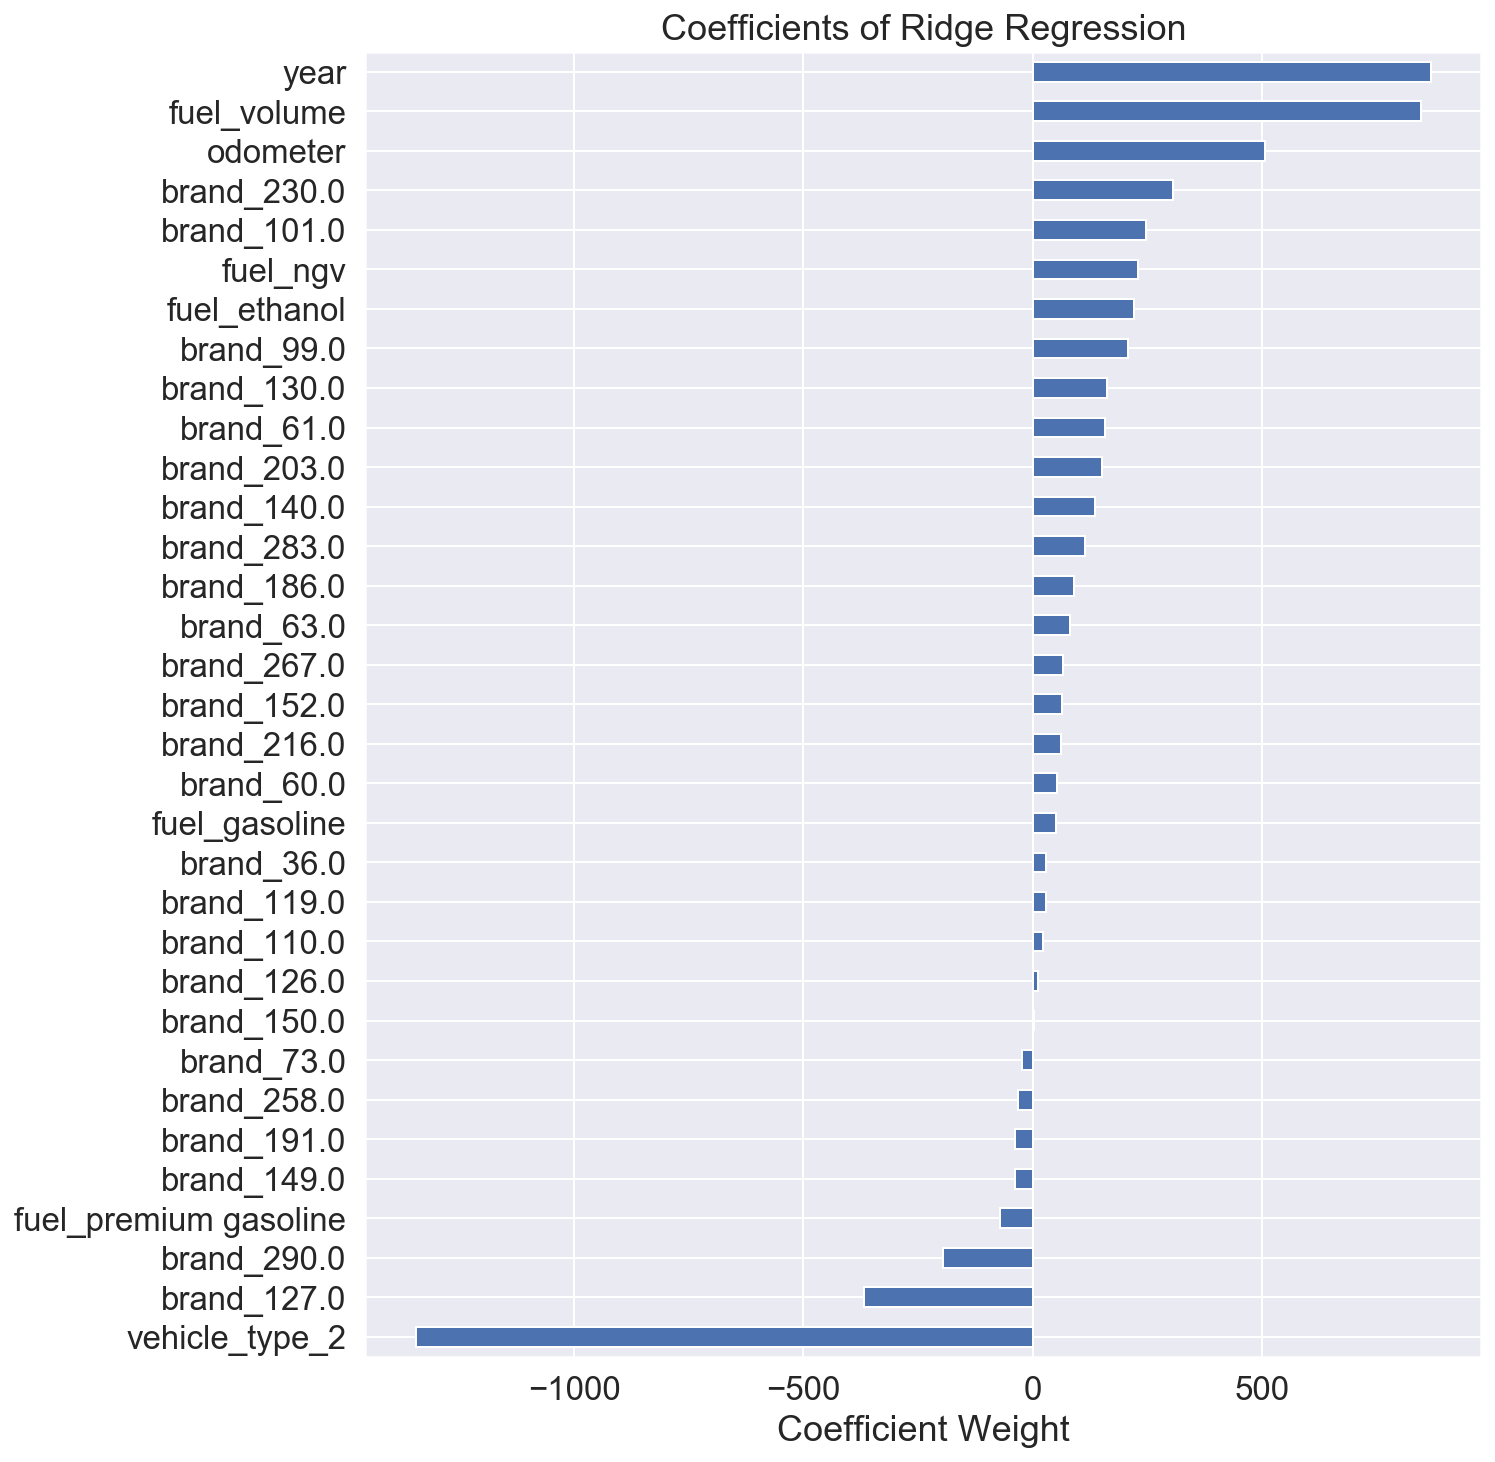

In [134]:
## Checkin Ridge coefficients

fig, ax = plt.subplots(figsize=(10,12))

ridge_coef = pd.DataFrame(ridge_cv.coef_, index=X_train.columns,
                       columns=['coefficients'])

ridge_coef.coefficients.sort_values().plot(kind='barh')

plt.title('Coefficients of Ridge Regression')
plt.xlabel('Coefficient Weight');

#### Lasso 

In [135]:
LassoCV = LassoCV(n_alphas = 500, cv=5)
LassoCV.fit(X_train, y_train)

lasso_train = LassoCV.score(X_train, y_train)
lasso_test = LassoCV.score(X_test, y_test)


print('Best alpha:', LassoCV.alpha_)
print('Lasso Training score:', lasso_train)
print("Lasso Test Score:", lasso_test)

Best alpha: 7.673874313408201
Lasso Training score: 0.5491459335737543
Lasso Test Score: 0.5495984703484396


In [140]:
lasso_coef = pd.DataFrame(LassoCV.coef_, index=X_train.columns, columns=['coefficients'])

lasso_coef['coef_abs'] = lasso_coef.coefficients.abs()


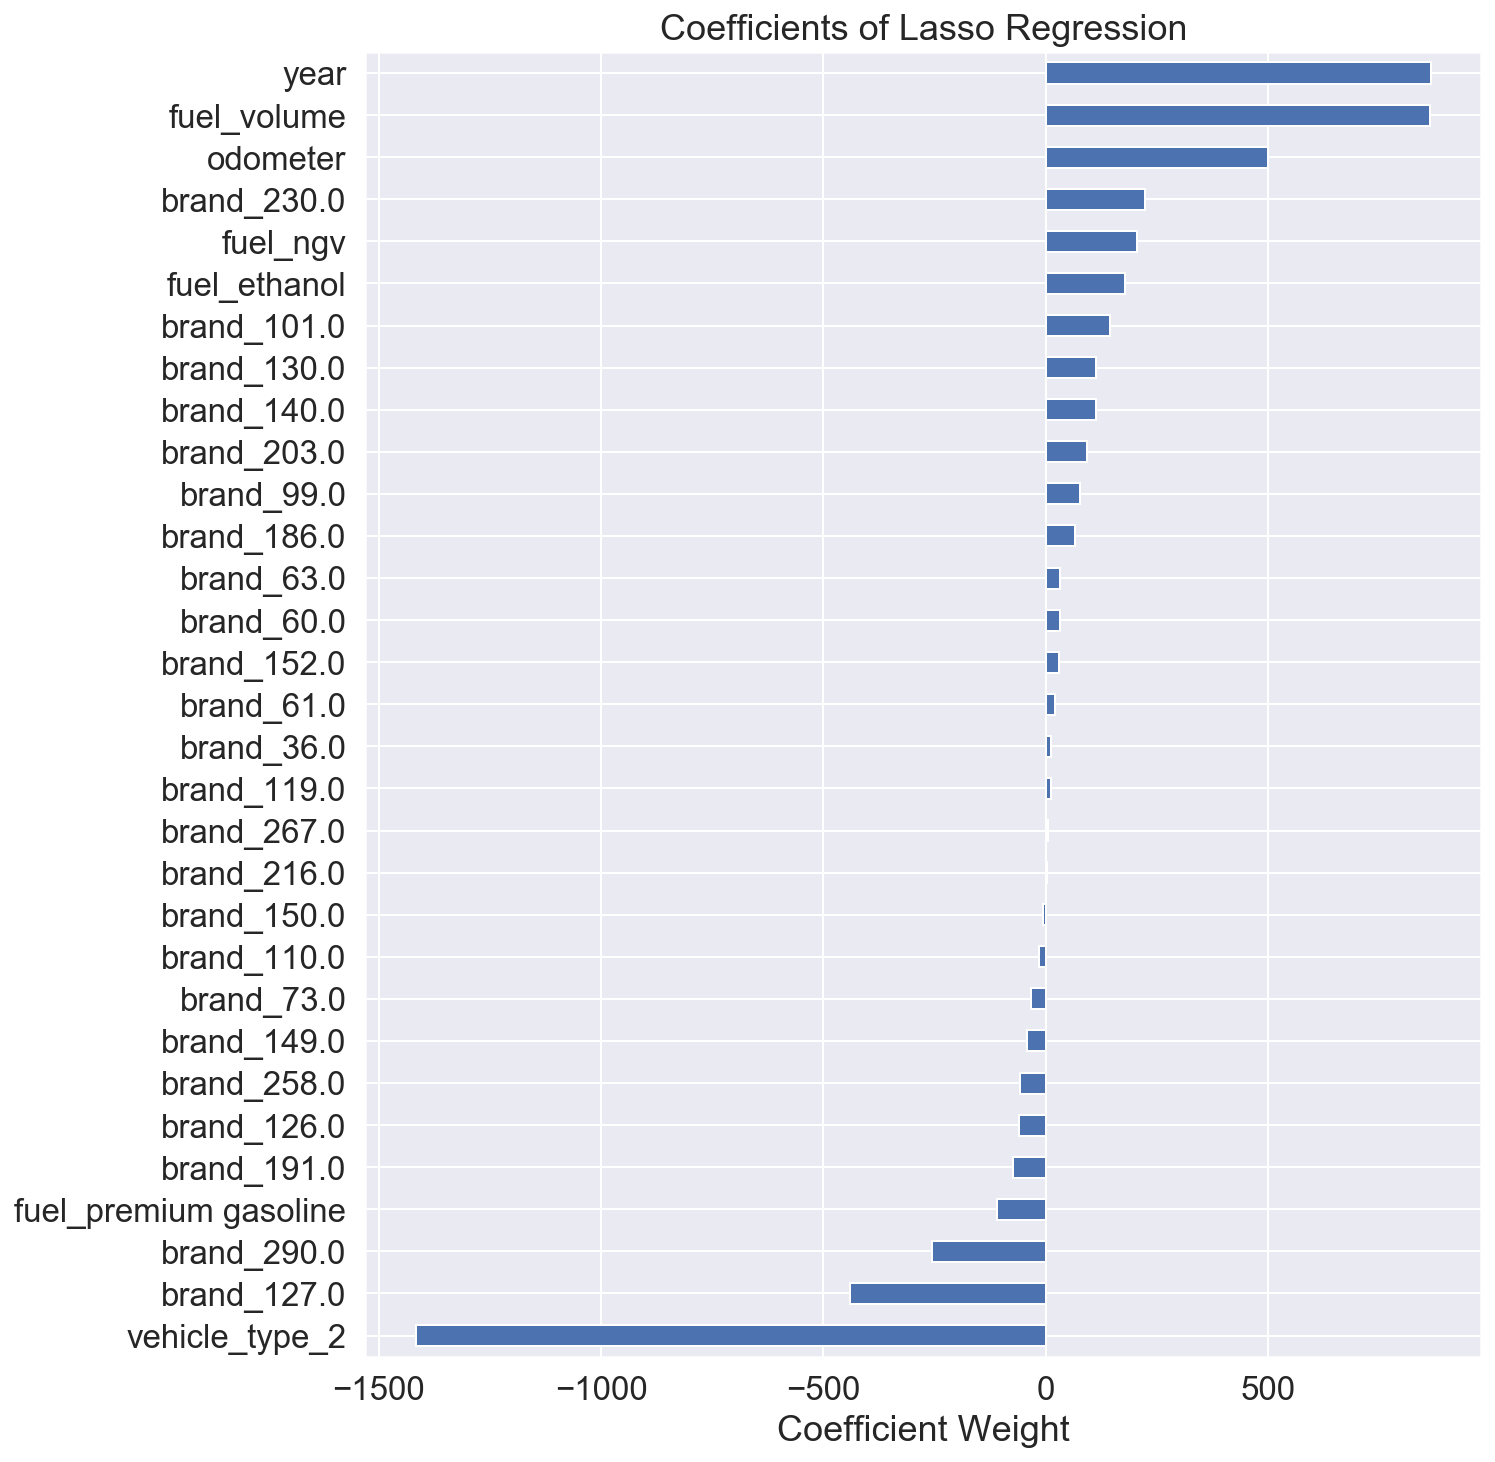

In [145]:
## Checking lasso coefficients

fig, ax = plt.subplots(figsize=(10,12))
lasso_coef[lasso_coef.coefficients != 0].coefficients.sort_values().plot(kind='barh')
plt.title('Coefficients of Lasso Regression')
plt.xlabel('Coefficient Weight');

### KNN

In [146]:
kn = KNeighborsRegressor()

In [147]:
## Gridsearch for best parameters

kn_params = {'n_neighbors': np.arange(1,100,5)}

kn_gridsearch = GridSearchCV(kn,
                             kn_params,
                               n_jobs=-1, 
                               cv=5, 
                               verbose=1)

In [148]:
kn_gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   48.6s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                           metric='minkowski',
                                           metric_params=None, n_jobs=None,
                                           n_neighbors=5, p=2,
                                           weights='uniform'),
             iid='warn', n_jobs=-1,
             param_grid={'n_neighbors': array([ 1,  6, 11, 16, 21, 26, 31, 36, 41, 46, 51, 56, 61, 66, 71, 76, 81,
       86, 91, 96])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=1)

In [149]:
# Looking for the best params
kn_gridsearch.best_params_

{'n_neighbors': 31}

In [150]:
kn_train = kn_gridsearch.best_estimator_.score(X_train, y_train)
kn_test = kn_gridsearch.best_estimator_.score(X_test, y_test)
kn_cv = kn_gridsearch.best_score_

print('K Neighbors Regressor train score:', kn_train)
print('K Neighbors Regressor test score:', kn_test)
print('K Neighbors Regressor mean CV score:', kn_cv)


K Neighbors Regressor train score: 0.5851772756658093
K Neighbors Regressor test score: 0.5660719286265559
K Neighbors Regressor mean CV score: 0.5550074058149846


### Decision Tree

In [151]:
tree = DecisionTreeRegressor()

In [152]:
## Gridsearch 

tree_params = {'max_depth': np.arange(2,11),
               'min_samples_split': np.arange(2,6),
               'min_samples_leaf': np.arange(1,10),
               'max_leaf_nodes': [None, 2, 3, 5]}

tree_gridsearch = GridSearchCV(tree,
                               tree_params,
                               n_jobs=2, 
                               cv=5, 
                               verbose=1)

In [153]:
tree_gridsearch.fit(X_train, y_train)


Fitting 5 folds for each of 1296 candidates, totalling 6480 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 544 tasks      | elapsed:    3.4s
[Parallel(n_jobs=2)]: Done 2644 tasks      | elapsed:   17.4s
[Parallel(n_jobs=2)]: Done 6144 tasks      | elapsed:   46.8s
[Parallel(n_jobs=2)]: Done 6480 out of 6480 | elapsed:   49.2s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeRegressor(criterion='mse', max_depth=None,
                                             max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort=False, random_state=None,
                                             splitter='best'),
             iid='warn', n_jobs=2,
             param_grid={'max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10]),
                         'max_leaf_nodes': [None, 2, 3, 5],
                         'min_samples_leaf': array([1, 2, 3, 4, 5, 6, 7,

In [154]:
tree_gridsearch.best_params_

{'max_depth': 6,
 'max_leaf_nodes': None,
 'min_samples_leaf': 9,
 'min_samples_split': 2}

In [155]:
tree_train = tree_gridsearch.best_estimator_.score(X_train, y_train)
tree_test = tree_gridsearch.best_estimator_.score(X_test, y_test)
tree_cv = tree_gridsearch.best_score_

print('Tree Regressor train score:', tree_train)
print('Tree Regressor test score:', tree_test)
print('Tree Regressor mean CV score:', tree_cv)

Tree Regressor train score: 0.5881978180905358
Tree Regressor test score: 0.5760243131543354
Tree Regressor mean CV score: 0.5664686957184835


In [156]:
predictions = tree_gridsearch.best_estimator_.predict(X_test)

print('Tree regressor train MSE: ', mean_squared_error(y_train, tree_gridsearch.best_estimator_.predict(X_train)))
print('Tree regressor test MSE: ', mean_squared_error(y_test, predictions))
print('Tree regressor CV MSE: ', -cross_val_score(tree_gridsearch.best_estimator_, X_train, y_train, cv=5, scoring='neg_mean_squared_error').mean())



Tree regressor train MSE:  7050484.273331871
Tree regressor test MSE:  7126142.243793143
Tree regressor CV MSE:  7421632.430903544


### Decision Tree Bagging Regressor

In [157]:
tree2 = DecisionTreeRegressor(max_depth=6)
bagg = BaggingRegressor(base_estimator=tree, random_state=1)

In [158]:
bagg_params = {'max_samples': [0.2, 0.5, 0.7, 1.0],
               'max_features':[0.2, 0.5, 0.7, 1.0],
              'base_estimator': [tree]}

bagg_gridsearch = GridSearchCV(bagg,
                               bagg_params,
                               n_jobs=-1, 
                               cv=5, 
                               verbose=1)

In [159]:
bagg_gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    6.5s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=BaggingRegressor(base_estimator=DecisionTreeRegressor(criterion='mse',
                                                                             max_depth=None,
                                                                             max_features=None,
                                                                             max_leaf_nodes=None,
                                                                             min_impurity_decrease=0.0,
                                                                             min_impurity_split=None,
                                                                             min_samples_leaf=1,
                                                                             min_samples_split=2,
                                                                             min_weight_fraction_leaf=0.0,
                                                           

In [160]:
bagg_gridsearch.best_params_

{'base_estimator': DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       presort=False, random_state=None, splitter='best'),
 'max_features': 1.0,
 'max_samples': 0.2}

In [161]:
bagg_train = bagg_gridsearch.best_estimator_.score(X_train, y_train)
bagg_test = bagg_gridsearch.best_estimator_.score(X_test, y_test)
bagg_cv = bagg_gridsearch.best_score_

print('Bagging Tree Regressor train score:', bagg_train)
print('Bagging Tree Regressor test score:', bagg_test)
print('Bagging Tree Regressor mean CV score:', bagg_cv)

Bagging Tree Regressor train score: 0.6742388578360528
Bagging Tree Regressor test score: 0.5457507058034502
Bagging Tree Regressor mean CV score: 0.5322049834741344


### Gradient Boosting

In [162]:
model = GradientBoostingRegressor(n_estimators=100,
                                  max_depth=3,
                                  learning_rate=0.2,
                                  random_state=1,
                                 n_iter_no_change=15, tol=0.01)
model.fit(X_train, y_train)

gboost_train = model.score(X_train, y_train)
gboost_test = model.score(X_test, y_test)
gboost_cv = cross_val_score(model, X_train, y_train, cv=5).mean()


print('Gradient boosting train score:', gboost_train)
print('Gradient boosting test score:', gboost_test)
print('Gradient boosting cv score:', gboost_cv)

Gradient boosting train score: 0.6076004116969719
Gradient boosting test score: 0.5884424125245232
Gradient boosting cv score: 0.577491512288149


In [163]:
## Gridsearch

boost = GradientBoostingRegressor(random_state=1, tol=0.01)

boost_params = {'n_estimators': [100, 150, 200, 300, 400, 500],
               'max_depth':[2, 3, 4, 6, 8, 10],
              'learning_rate': [0.1, 0.2, 0.4, 0.6], 
               'n_iter_no_change': [5, 10, 15]}

boost_gridsearch = GridSearchCV(boost,
                               boost_params,
                               n_jobs=2, 
                               cv=5, 
                               verbose=1)


In [164]:
boost_gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   12.9s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   55.0s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  2.7min
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:  4.6min
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:  6.5min
[Parallel(n_jobs=2)]: Done 1796 tasks      | elapsed:  7.9min
[Parallel(n_jobs=2)]: Done 2160 out of 2160 | elapsed:  9.0min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GradientBoostingRegressor(alpha=0.9,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_iter...
                             

In [165]:
boost_gridsearch.best_params_

{'learning_rate': 0.2,
 'max_depth': 3,
 'n_estimators': 100,
 'n_iter_no_change': 10}

In [166]:
boost_train = boost_gridsearch.best_estimator_.score(X_train, y_train)
boost_test = boost_gridsearch.best_estimator_.score(X_test, y_test)
boost_cv = boost_gridsearch.best_score_

print('Boosting Regressor train score:', boost_train)
print('Boosting Regressor test score:', boost_test)
print('Boosting Regressor mean CV score:', boost_cv)

Boosting Regressor train score: 0.6071174838874158
Boosting Regressor test score: 0.5890934672725374
Boosting Regressor mean CV score: 0.5777678779304639


### Random Forest

In [167]:
forest = RandomForestRegressor(max_depth=None, n_estimators=100)

In [168]:
forest.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [169]:
forest_train = forest.score(X_train, y_train)
forest_test = forest.score(X_test, y_test)
forest_cv = cross_val_score(forest, X_train, y_train, cv=5).mean()

print('Forest Regressor train score:', forest_train)
print('Forest Regressor test score:', forest_test)
print('Forest Regressor mean CV score:', forest_cv)

Forest Regressor train score: 0.9351942416180256
Forest Regressor test score: 0.5532667229166714
Forest Regressor mean CV score: 0.5318719841561197


In [170]:
## Gridsearch

random_forest = RandomForestRegressor(random_state=1)


randomf_params = {'max_depth': np.arange(1,20,1),
              'max_leaf_nodes': [None, 2, 5, 8],
              'min_samples_leaf': [5, 10],
                 'n_estimators': ['warn', 10, 15, 50, 100, 500]} 

randomf_gridsearch = GridSearchCV(random_forest,
                               randomf_params,
                               n_jobs=-1, 
                               cv=5, 
                               verbose=1)


In [171]:
randomf_gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 912 candidates, totalling 4560 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   25.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  9.6min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 14.3min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed: 20.3min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 27.6min
[Parallel(n_jobs=-1)]: Done 4560 out of 4560 | elapsed: 31.6min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=1,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': array([ 1,  2,  3,  4, 

In [172]:
randomf_gridsearch.best_params_

{'max_depth': 7,
 'max_leaf_nodes': None,
 'min_samples_leaf': 5,
 'n_estimators': 500}

In [173]:
randomf_train = randomf_gridsearch.best_estimator_.score(X_train, y_train)
randomf_test = randomf_gridsearch.best_estimator_.score(X_test, y_test)
randomf_cv = randomf_gridsearch.best_score_

print('Forest Regressor train score:', randomf_train)
print('Forest Regressor test score:', randomf_test)
print('Forest Regressor mean CV score:', randomf_cv)

Forest Regressor train score: 0.6100317490640532
Forest Regressor test score: 0.5903139653082061
Forest Regressor mean CV score: 0.5789084502566242


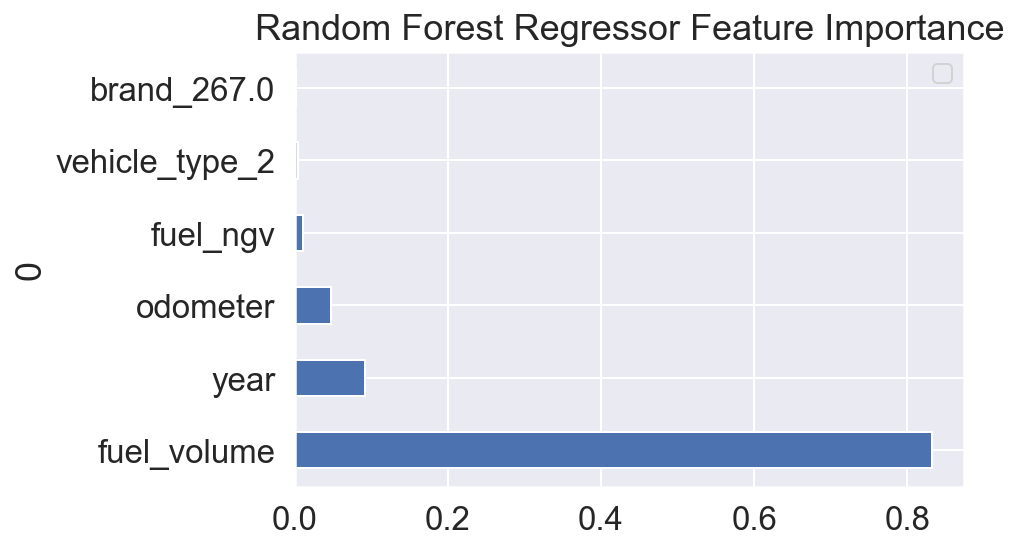

In [175]:
from matplotlib.font_manager import FontProperties

pd.DataFrame(list(zip(X_train.columns,randomf_gridsearch.best_estimator_[1].feature_importances_))).sort_values(by=1,ascending=False).iloc[:6].plot(kind='barh',
    x=0,y=1)
fontP = FontProperties()
fontP.set_size(12)
plt.legend('', prop=fontP, mode='bbox_to_anchor')
plt.title('Random Forest Regressor Feature Importance')
plt.show()

In [177]:
## Plotting the residuals disribution to evaluate the model

y_hat = randomf_gridsearch.best_estimator_.predict(X_test)
residuals = y_test - y_hat


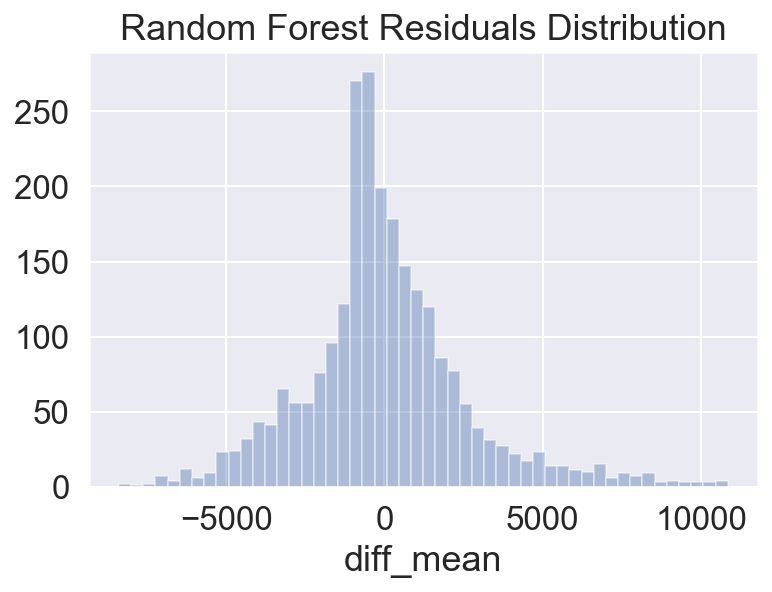

In [178]:
sns.distplot(residuals, hist=True, kde=False)
plt.title('Random Forest Residuals Distribution')
plt.show()

### Comparing the model's scores

In [179]:
comparisson_df = pd.DataFrame([[lr_train, ridge_train, lasso_train, kn_train, tree_train, bagg_train, boost_train, randomf_train],\
                               [lr_test, ridge_test, lasso_test, kn_test, tree_test, bagg_test, boost_test, randomf_test],\
                              [lr_cv, np.nan, np.nan, kn_cv, tree_cv, bagg_cv, boost_cv, randomf_cv]], 
                              columns=['Linear Regression CV','Ridge CV', 'Lasso CV', 'KNeighbors', 'Decision Tree', 'Bagging', 'Boosting','Random Forest'], \
                              index= ['Train score', 'Test score', 'Mean CV score'])
comparisson_df.T.sort_values(by='Test score', ascending=False)


,Train score,Test score,Mean CV score
Random Forest,0.610032,0.590314,0.578908
Boosting,0.607117,0.589093,0.577768
Decision Tree,0.588198,0.576024,0.566469
KNeighbors,0.585177,0.566072,0.555007
Linear Regression CV,0.549399,0.550398,0.544465
Ridge CV,0.549337,0.550355,NaN
Lasso CV,0.549146,0.549598,NaN
Bagging,0.674239,0.545751,0.532205


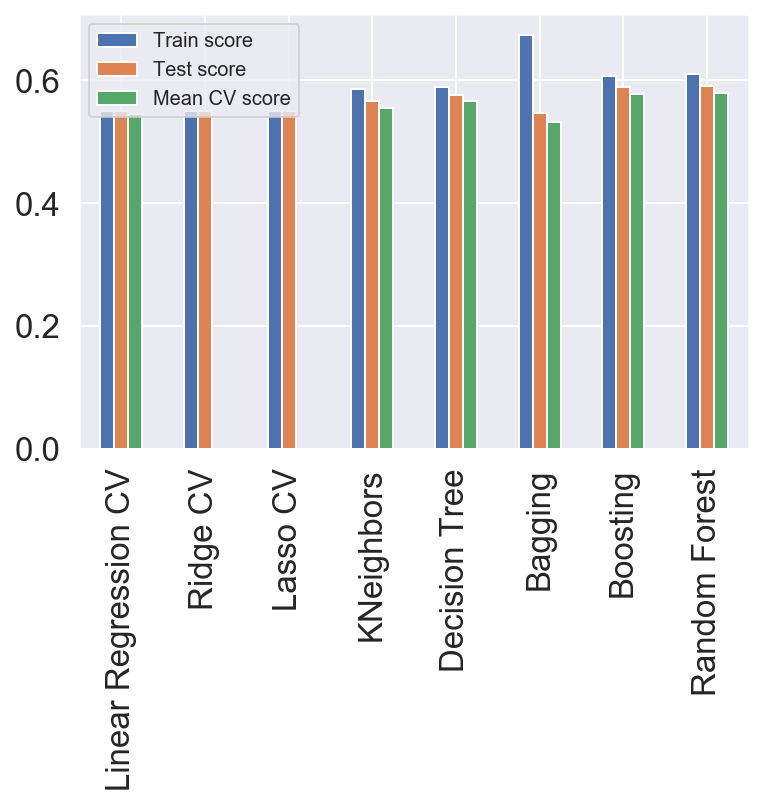

In [180]:
from matplotlib.font_manager import FontProperties
comparisson_df.T.plot(kind='bar')
fontP = FontProperties()
fontP.set_size(10)
plt.legend(prop=fontP) 
plt.xticks(range(8), rotation=90);

# Conclusions

After comparing 8 different regression models on their cross validated and test R squared scores, the best result I got was from the random forest regressor model. I also observed that all the models were good at generalising since the test and cross validated scores did not differ greatly in any of the models.

The random forest regressor model showed that around 59% of the variation on the target is explained by the independent variables. Although an R squared score of 0.59 is not necessarily good,  it is accurate to say that the model performed better than the baseline that, in a regression scenario, is the mean of the target variable. Also, since the score is positive, it is right to assume that the Residual Sum of Squares (RSS) is smaller than the Total Sum of Squares, which is another indicator of a good model.

Because the R squared is a measure that doesn’t convey the reliability of the model, I also checked for the residuals distribution that showed a gaussian curve kind of distribution. Normally distributed residuals indicates that the regression is modelling the linear relationship appropriately and that the assumptions of the linear regression are probably being met.

Those reasons, added to the fact that I don’t need to know the weight of my variables for the app’s predictions and also considering that the app aims to make a suggestion rather then being precise, the Random Forest regressor seems like a good model of choice.

## Next steps

- Investigate further the role of the features on vehicle performance  
- Expand the model for other countries
- Create model for different services
- Improve the user interaction inside the app and data management


